In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import seaborn as sns
import numpy as np
import os
from os.path import join
from pathlib import Path
from statsmodels.tsa.tsatools import detrend
import statsmodels.formula.api as sm
import itertools
import sys
import calendar
import datetime
# sns.set()
idx = pd.IndexSlice

In [2]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [44]:
%aimport Analysis.index
from Analysis.index import facility_co2, adjust_epa_emissions, group_fuel_cats
from Analysis.index import reduce_emission_factors, add_datetime
%aimport util.utils
from util.utils import rename_cols

%aimport Plots.plot
from Plots.plot import region_facet_grid, rolling_corr_plot

## Load CO₂ intensity and percent gen data

### CO₂ intensity (aka *index*)

In [155]:
cwd = os.getcwd()
path = join(cwd, '..', 'Data storage', 'National data', 'National index.csv')
national_index = pd.read_csv(path, parse_dates=['datetime'])
national_index['nerc'] = 'USA'
rename_cols(national_index)

In [156]:
national_index.head()

year  month  generation (mwh)  final co2 (kg)   datetime  quarter  \
0  2001      1       332493160.0    2.149920e+11 2001-01-01        1   
1  2001      2       282940198.0    1.803140e+11 2001-02-01        1   
2  2001      3       300706544.0    1.891340e+11 2001-03-01        1   
3  2001      4       278078871.0    1.748850e+11 2001-04-01        2   
4  2001      5       300491621.0    1.892470e+11 2001-05-01        2   

   index (g/kwh)  change since 2005  index (lb/mwh) nerc  
0     646.604591           0.076326     1425.504481  USA  
1     637.284923           0.060812     1404.958340  USA  
2     628.965732           0.046964     1386.617853  USA  
3     628.902838           0.046860     1386.479197  USA  
4     629.790069           0.048337     1388.435187  USA

In [157]:
path = join(cwd, '..', 'Data storage',
            'final NERC data', 'NERC gen emissions and index.csv')
nerc_index = pd.read_csv(path, parse_dates=['datetime'])
nerc_index.rename(columns={'index': 'index (g/kwh)'}, inplace=True)

In [158]:
nerc_index.head()

year  nerc  month  final co2 (kg)  generation (mwh)  index (g/kwh)  \
0  2001  ASCC      1    2.786751e+08        518671.808     537.286023   
1  2001  ASCC      2    2.705489e+08        465585.412     581.093945   
2  2001  ASCC      3    2.955631e+08        502360.773     588.348284   
3  2001  ASCC      4    2.363164e+08        424283.698     556.977386   
4  2001  ASCC      5    2.312179e+08        416352.432     555.341754   

    datetime  
0 2001-01-01  
1 2001-02-01  
2 2001-03-01  
3 2001-04-01  
4 2001-05-01

### Percent generation

In [159]:
path = join(cwd, '..', 'Data storage',
            'National data', 'National percent gen.csv')
national_per_gen = pd.read_csv(path)
add_datetime(national_per_gen)
national_per_gen['nerc'] = 'USA'
national_per_gen.rename(columns={'generation (mwh)': '% generation'},
                        inplace=True)

In [160]:
national_per_gen.head()

year  month fuel category  % generation   datetime nerc
0  2001      1          Coal      0.533205 2001-01-01  USA
1  2001      2          Coal      0.529212 2001-02-01  USA
2  2001      3          Coal      0.516347 2001-03-01  USA
3  2001      4          Coal      0.505866 2001-04-01  USA
4  2001      5          Coal      0.504483 2001-05-01  USA

In [161]:
path = join(cwd, '..', 'Data storage',
            'final NERC data', 'NERC percent gen.csv')
nerc_per_gen = pd.read_csv(path, parse_dates=['datetime'])

In [162]:
nerc_per_gen.head()

fuel category   datetime  nerc  % generation
0          Coal 2001-01-01  ASCC      0.051079
1          Coal 2001-02-01  ASCC      0.067149
2          Coal 2001-03-01  ASCC      0.056652
3          Coal 2001-04-01  ASCC      0.048213
4          Coal 2001-05-01  ASCC      0.057876

### Absolute generation

In [163]:
path = join(cwd, '..', 'Data storage',
            'National data', 'National generation.csv')
national_gen = pd.read_csv(path)
add_datetime(national_gen)
national_gen['nerc'] = 'USA'

In [164]:
national_gen.head()

fuel category  year  month  generation (mwh)   datetime nerc
0          Coal  2001      1       177287111.0 2001-01-01  USA
1          Coal  2001      2       149735484.0 2001-02-01  USA
2          Coal  2001      3       155269011.0 2001-03-01  USA
3          Coal  2001      4       140670654.0 2001-04-01  USA
4          Coal  2001      5       151592914.0 2001-05-01  USA

In [165]:
index_cols = ['nerc', 'generation (mwh)', 'datetime']
nerc_gen = pd.merge(nerc_per_gen, nerc_index[index_cols],
                    on=['nerc', 'datetime'])
nerc_gen.rename(columns={'generation (mwh)' : 'total generation (mwh)'},
                inplace=True)
nerc_gen['generation (mwh)'] = (nerc_gen['% generation']
                                * nerc_gen['total generation (mwh)'])
nerc_gen.set_index(['nerc', 'fuel category', 'datetime'], inplace=True)
nerc_gen.head()

% generation  total generation (mwh)  \
nerc fuel category datetime                                           
ASCC Coal          2001-01-01      0.051079              518671.808   
     Hydro         2001-01-01      0.215525              518671.808   
     Natural Gas   2001-01-01      0.605791              518671.808   
     Other         2001-01-01      0.127438              518671.808   
     Wind          2001-01-01      0.000167              518671.808   

                               generation (mwh)  
nerc fuel category datetime                      
ASCC Coal          2001-01-01         26493.302  
     Hydro         2001-01-01        111786.609  
     Natural Gas   2001-01-01        314206.726  
     Other         2001-01-01         66098.653  
     Wind          2001-01-01            86.518

#### Add generation by different fuel sources to get total generation by NERC

In [166]:
total = nerc_gen.groupby(['nerc', 'datetime'])['% generation',
                                               'generation (mwh)'].sum()
total['fuel category'] = 'Total'
total.set_index('fuel category', append=True, inplace=True)
total = total.reorder_levels(['nerc', 'fuel category', 'datetime'])
total.head()

% generation  generation (mwh)
nerc fuel category datetime                                  
ASCC Total         2001-01-01           1.0        518671.808
                   2001-02-01           1.0        465585.412
                   2001-03-01           1.0        502360.773
                   2001-04-01           1.0        424283.698
                   2001-05-01           1.0        416352.432

In [167]:
nerc_gen = pd.concat([nerc_gen, total])
nerc_gen.sort_index(inplace=True)

In [168]:
nerc_gen.head()

% generation  generation (mwh)  \
nerc fuel category datetime                                     
ASCC Coal          2001-01-01      0.051079         26493.302   
                   2001-02-01      0.067149         31263.704   
                   2001-03-01      0.056652         28459.894   
                   2001-04-01      0.048213         20455.924   
                   2001-05-01      0.057876         24096.734   

                               total generation (mwh)  
nerc fuel category datetime                            
ASCC Coal          2001-01-01              518671.808  
                   2001-02-01              465585.412  
                   2001-03-01              502360.773  
                   2001-04-01              424283.698  
                   2001-05-01              416352.432

## Load capacity by month, fuel, nerc

In [184]:
path = join(cwd, '..', 'Data storage',
            'Plant Capacity', 'monthly capacity by fuel.csv')

capacity = pd.read_csv(path, index_col=['nerc', 'fuel category', 'datetime'],
                       parse_dates=['datetime'])
capacity.drop(['year', 'month'], axis=1, inplace=True)

In [185]:
capacity.head()

active capacity  possible gen
nerc fuel category datetime                                 
ASCC Coal          2001-01-01            117.5       87420.0
                   2001-02-01            117.5       78960.0
                   2001-03-01            117.5       87420.0
                   2001-04-01            117.5       84600.0
                   2001-05-01            117.5       87420.0

In [186]:
national_capacity = capacity.groupby(['fuel category', 'datetime']).sum()
national_capacity['nerc'] = 'USA'
national_capacity.set_index('nerc', append=True, inplace=True)
national_capacity = national_capacity.reorder_levels(['nerc', 'fuel category', 'datetime'])
national_capacity.head()

active capacity  possible gen
nerc fuel category datetime                                 
USA  Coal          2001-01-01         325145.5   241908252.0
                   2001-02-01         325145.5   218497776.0
                   2001-03-01         325145.5   241908252.0
                   2001-04-01         325659.2   234474624.0
                   2001-05-01         325659.2   242290444.8

In [187]:
capacity = pd.concat([capacity, national_capacity])
capacity.sort_index(inplace=True)
capacity.tail()

active capacity  possible gen
nerc fuel category datetime                                 
WECC Wind          2017-08-01          19994.6    14875982.4
                   2017-09-01          19994.6    14396112.0
                   2017-10-01          19994.6    14875982.4
                   2017-11-01          19994.6    14396112.0
                   2017-12-01          19994.6    14875982.4

## Combine NERC and national results

### CO₂ intensity

In [173]:
index = pd.concat([national_index, nerc_index])

In [174]:
index.head()

change since 2005   datetime  final co2 (kg)  generation (mwh)  \
0           0.076326 2001-01-01    2.149920e+11       332493160.0   
1           0.060812 2001-02-01    1.803140e+11       282940198.0   
2           0.046964 2001-03-01    1.891340e+11       300706544.0   
3           0.046860 2001-04-01    1.748850e+11       278078871.0   
4           0.048337 2001-05-01    1.892470e+11       300491621.0   

   index (g/kwh)  index (lb/mwh)  month nerc  quarter  year  
0     646.604591     1425.504481      1  USA      1.0  2001  
1     637.284923     1404.958340      2  USA      1.0  2001  
2     628.965732     1386.617853      3  USA      1.0  2001  
3     628.902838     1386.479197      4  USA      2.0  2001  
4     629.790069     1388.435187      5  USA      2.0  2001

### Percent generation

In [175]:
per_gen = pd.concat([national_per_gen, nerc_per_gen])

per_gen.year = per_gen['datetime'].dt.year
per_gen.month = per_gen['datetime'].dt.month

In [176]:
per_gen.head()

% generation   datetime fuel category  month nerc  year
0      0.533205 2001-01-01          Coal      1  USA  2001
1      0.529212 2001-02-01          Coal      2  USA  2001
2      0.516347 2001-03-01          Coal      3  USA  2001
3      0.505866 2001-04-01          Coal      4  USA  2001
4      0.504483 2001-05-01          Coal      5  USA  2001

### Total generation

In [177]:
national_gen.head()

fuel category  year  month  generation (mwh)   datetime nerc
0          Coal  2001      1       177287111.0 2001-01-01  USA
1          Coal  2001      2       149735484.0 2001-02-01  USA
2          Coal  2001      3       155269011.0 2001-03-01  USA
3          Coal  2001      4       140670654.0 2001-04-01  USA
4          Coal  2001      5       151592914.0 2001-05-01  USA

In [178]:
cols = ['nerc', 'fuel category', 'datetime']
gen = pd.concat([national_gen.set_index(cols), nerc_gen])
gen.sort_index(inplace=True)
gen.drop(['% generation', 'total generation (mwh)'], axis=1,
         inplace=True)

In [179]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
ASCC Coal          2001-01-01         26493.302    NaN   NaN
                   2001-02-01         31263.704    NaN   NaN
                   2001-03-01         28459.894    NaN   NaN
                   2001-04-01         20455.924    NaN   NaN
                   2001-05-01         24096.734    NaN   NaN

## Figures

In [180]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('notebook', font_scale=1.2)

### Total generation

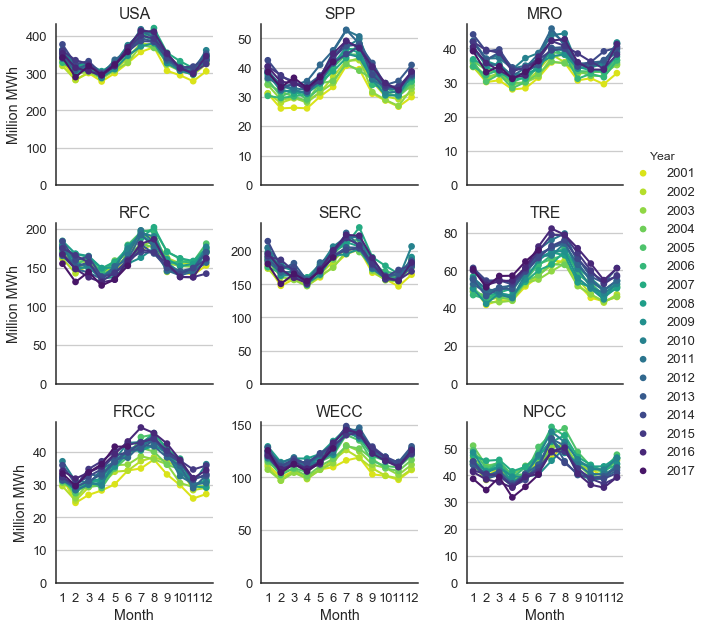

In [80]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = (gen.reset_index()
           .groupby(['nerc', 'datetime'])
           .sum()
           .reset_index())
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['generation (mwh)'] /= 1E6

# temp.rename(columns={'month': 'Month',
#                      'year': 'Year'}, inplace=True)
with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='generation (mwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3, sharey=False)
    
    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, None)
        
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Million MWh')
            
path = join(cwd, '..', 'Figures', 'Monthly generation.pdf')
plt.savefig(path, bbox_inches='tight')

In [62]:
convert_tick(list(ax.get_yticklabels())[-1])

''

In [55]:
list(ax.get_yticklabels())[-1].get_text()

''

In [53]:
for label in yticklabels:
    print(label.get_text())

0
1
2
3
4
5



In [49]:
yticklabels = ax.get_yticklabels()
new_yticklabels = [float(i.get_text()) for i in yticklabels]
new_yticklabels

ValueError: could not convert string to float: 

### Index figure

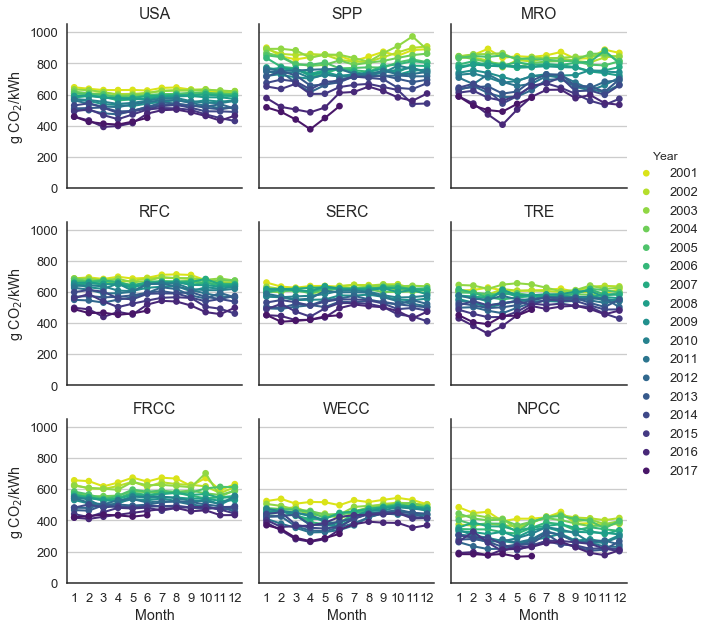

In [46]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = index.copy()
temp.rename(columns={'month': 'Month',
                     'year': 'Year'}, inplace=True)
with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='index (g/kwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('g CO$_2$/kWh')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')
plt.savefig(path, bbox_inches='tight')

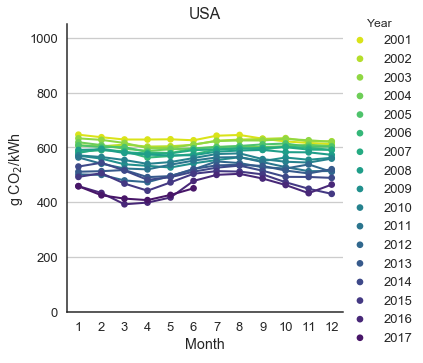

In [61]:
order = ['USA']#, 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = index.loc[index['nerc'] == 'USA'].copy()
temp.rename(columns={'month': 'Month',
                     'year': 'Year'}, inplace=True)
with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='index (g/kwh)', hue='Year', 
                       data=temp, #col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=5)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('g CO$_2$/kWh')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months) USA.pdf')
plt.savefig(path, bbox_inches='tight')

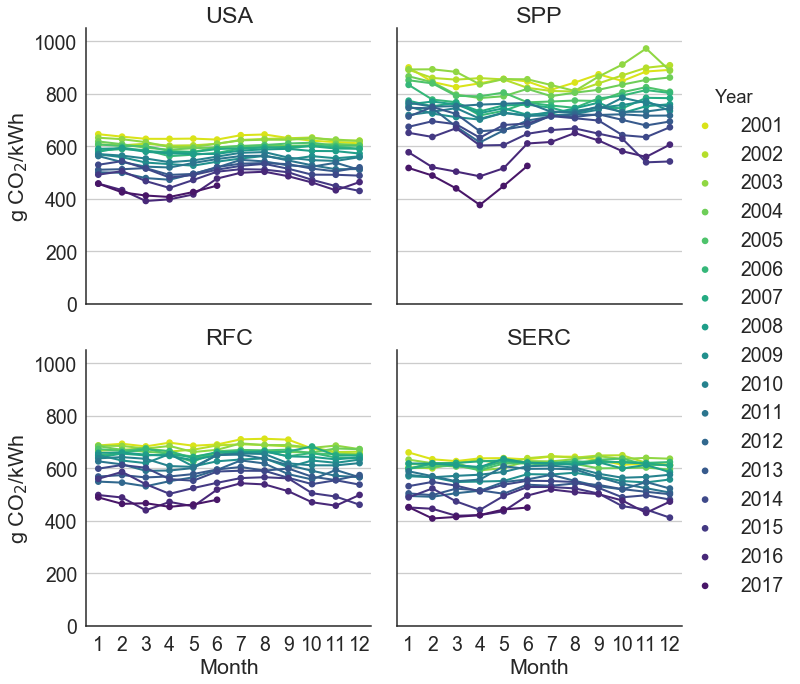

In [65]:
order = ['USA', 'SPP', 'RFC', 'SERC']#, 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = index.loc[index['nerc'].isin(order)].copy()
temp.rename(columns={'month': 'Month',
                     'year': 'Year'}, inplace=True)
with sns.plotting_context('talk', font_scale=1.5):

    g = sns.factorplot(x='Month', y='index (g/kwh)', hue='Year', 
                       data=temp, col='nerc', col_wrap=2, col_order=order, 
                       palette='viridis_r', scale=0.5, size=5)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('g CO$_2$/kWh')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months) 4 regions.pdf')
plt.savefig(path, bbox_inches='tight')

#### Alternate plot of CO₂ intensity

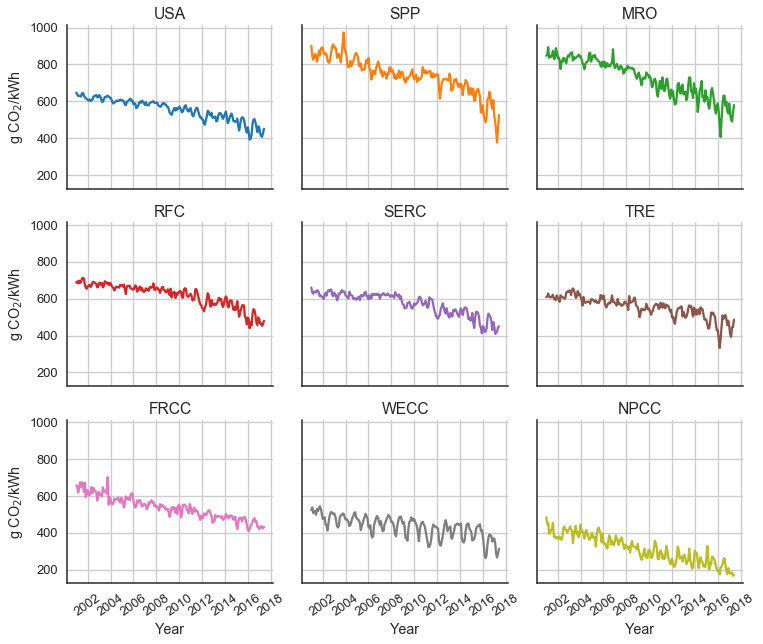

In [47]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='talk', font_scale=1)
path = join(cwd, '..', 'Figures', 'SI', 'Monthly index by region.pdf')
plt.savefig(path, bbox_inches='tight')

In [29]:
index.head()

change since 2005   datetime  final co2 (kg)  generation (mwh)  \
0           0.076326 2001-01-01    2.149920e+11       332493160.0   
1           0.060812 2001-02-01    1.803140e+11       282940198.0   
2           0.046964 2001-03-01    1.891340e+11       300706544.0   
3           0.046860 2001-04-01    1.748850e+11       278078871.0   
4           0.048337 2001-05-01    1.892470e+11       300491621.0   

   index (g/kwh)  index (lb/mwh)  month nerc  quarter  year  
0     646.604591     1425.504481      1  USA      1.0  2001  
1     637.284923     1404.958340      2  USA      1.0  2001  
2     628.965732     1386.617853      3  USA      1.0  2001  
3     628.902838     1386.479197      4  USA      2.0  2001  
4     629.790069     1388.435187      5  USA      2.0  2001

In [43]:
colors = [(r * 256, g * 265, b * 256) for (r, g, b) in sns.color_palette('tab10', n_colors=10)]

list(zip(range(1,11), colors))

[(1, (31.12156862745098, 123.66666666666667, 180.70588235294119)),
 (2, (256.0, 131.98039215686273, 14.054901960784314)),
 (3, (44.172549019607843, 166.27450980392157, 44.172549019607843)),
 (4, (214.83921568627451, 40.529411764705884, 40.156862745098039)),
 (5, (148.58039215686276, 107.03921568627452, 189.74117647058824)),
 (6, (140.54901960784315, 89.372549019607845, 75.294117647058826)),
 (7, (227.89019607843136, 123.66666666666667, 194.76078431372548)),
 (8, (127.49803921568628, 131.98039215686273, 127.49803921568628)),
 (9, (188.7372549019608, 196.41176470588235, 34.133333333333333)),
 (10, (23.090196078431372, 197.45098039215688, 207.81176470588235))]

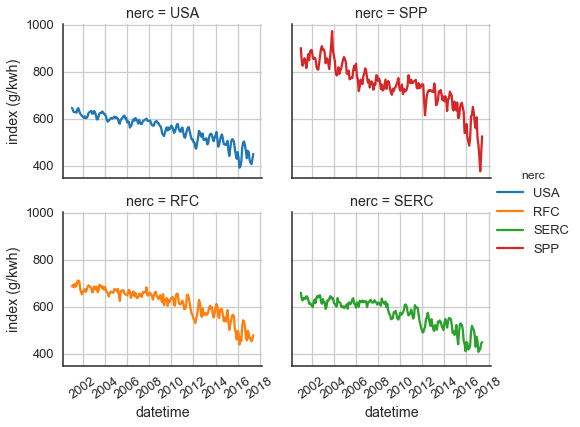

In [46]:
order = ['USA', 'SPP', 'RFC', 'SERC']
df = index.loc[index['nerc'].isin(order)]

g = sns.FacetGrid(df, col='nerc', col_wrap=2, col_order=order,
                  hue='nerc', palette='tab10', aspect=1.2)
g.map(plt.plot, 'datetime', 'index (g/kwh)').add_legend()
g.set_xticklabels(rotation=35)

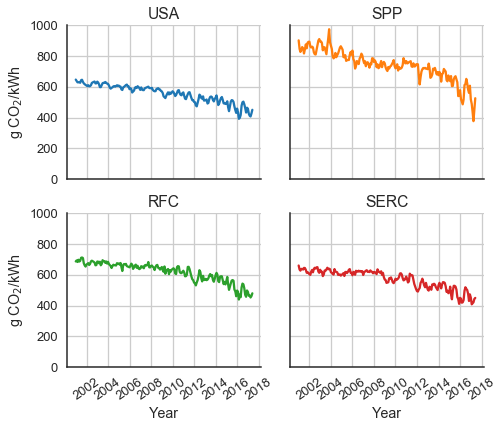

In [54]:
order = ['USA', 'SPP', 'RFC', 'SERC']#, 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=2,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='talk', font_scale=1)
plt.ylim(0, 1000)
path = join(cwd, '..', 'Figures', 'SI', 'Monthly index 4 regions.pdf')
plt.savefig(path, bbox_inches='tight')

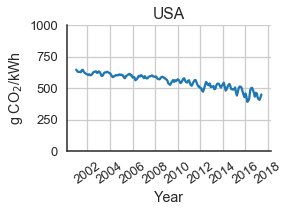

In [53]:
order = ['USA']#, 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=2,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='talk', font_scale=1)
plt.ylim(0, 1000)
path = join(cwd, '..', 'Figures', 'SI', 'Monthly index USA.pdf')
plt.savefig(path, bbox_inches='tight')

#### Plot of detrended intensity, using a linear detrend
Not a good method - trend isn't linear

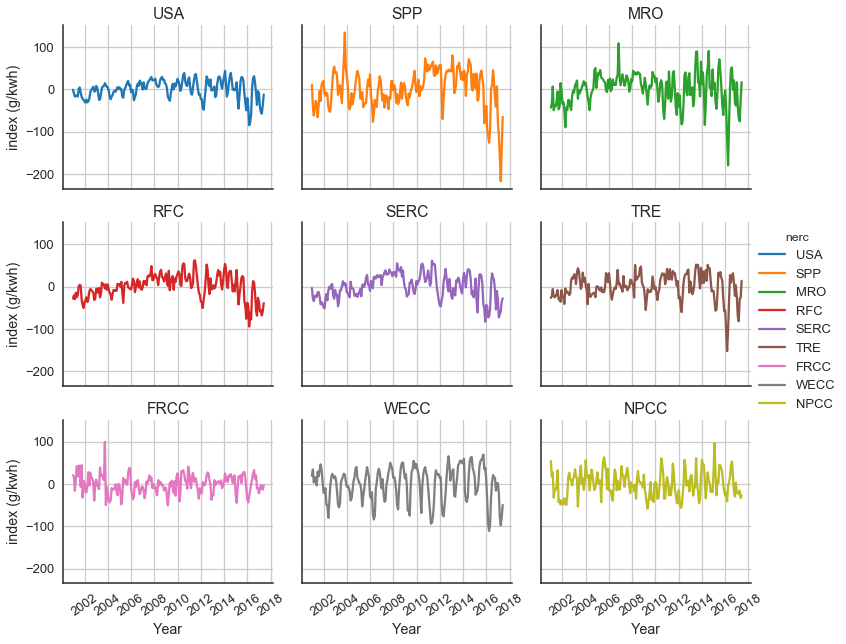

In [48]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Plot of detrended intensity using a first difference detrend
Better than linear, but I'm not sure it's appropriate

In [49]:
def diff_detrend(series, n=1):
    d = series - series.shift(n)
    return d

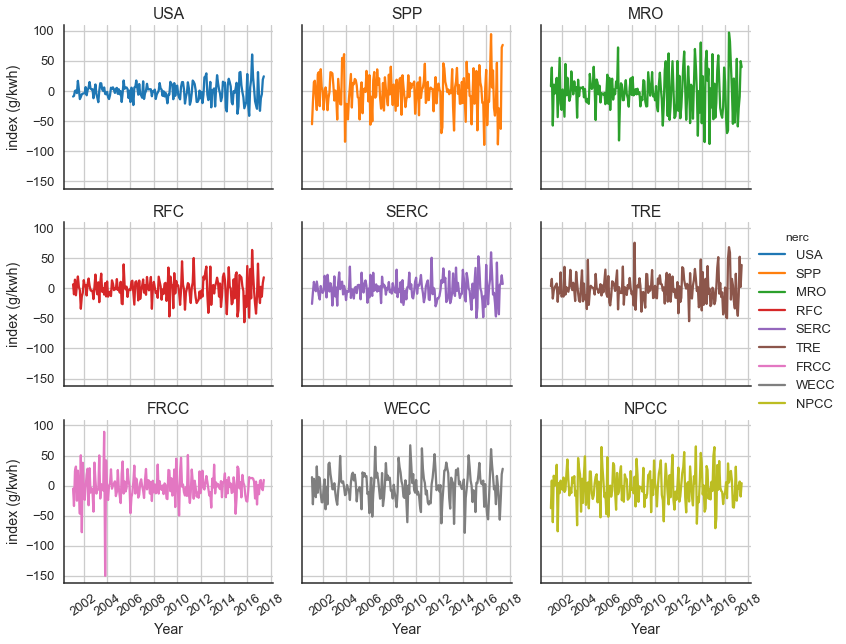

In [50]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'])


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

Using a difference from same month in the previous year rather than previous month.

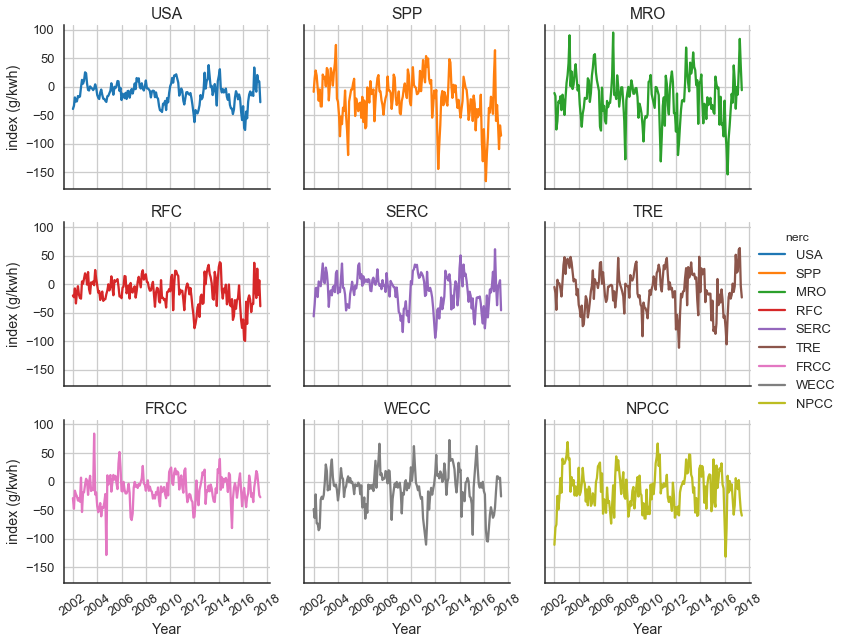

In [51]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

detrend_index = index.copy()
detrend_index.set_index(['nerc', 'datetime'], inplace=True)
detrend_index.sort_index(inplace=True)
for nerc in order:
    detrend_index.loc[idx[nerc, :], 'index (g/kwh)'] = diff_detrend(detrend_index.loc[idx[nerc, :], 'index (g/kwh)'], 12)


region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Detrend by subtracting the rolling 1-year mean

Started by using `seasonal_decompose` from statsmodels. It was apparent that the `trend` component is just the rolling average. I'm leaving the extra code here as documentation of this fact.

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [53]:
wecc = index.loc[index['nerc'] == 'WECC', ['index (g/kwh)', 'datetime']]
wecc.set_index('datetime', inplace=True)
wecc.head()

index (g/kwh)
datetime                 
2001-01-01     524.331566
2001-02-01     538.398535
2001-03-01     507.408432
2001-04-01     518.650607
2001-05-01     517.016964

In [54]:
sd = seasonal_decompose(wecc)

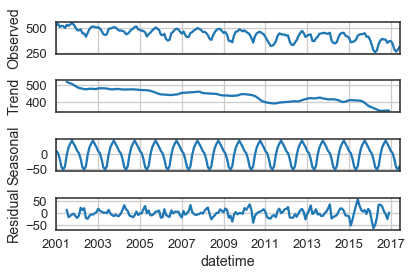

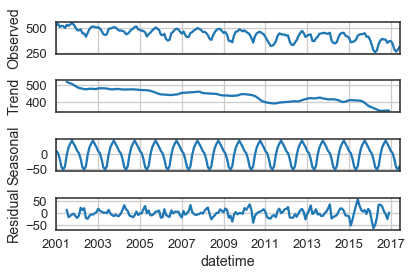

In [55]:
sd.plot()

These three things are all the same:
1. Subtracting just the *trend* from the `WECC` data
2. Adding the *seasonal* and *resid* components
3. Subtracting the annual rolling mean from the `WECC` data

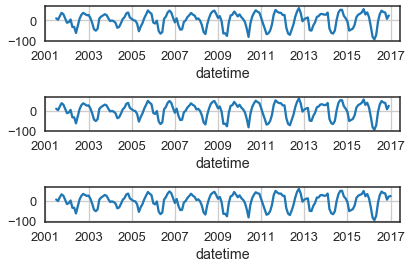

In [56]:
fig, ax = plt.subplots(nrows=3, squeeze=True)
(wecc - sd.trend).plot(ax=ax[0], legend=False)
(sd.seasonal + sd.resid).plot(ax=ax[1], legend=False)
(wecc - wecc.rolling(12, center=True).mean()).plot(ax=ax[2], legend=False)
plt.tight_layout()

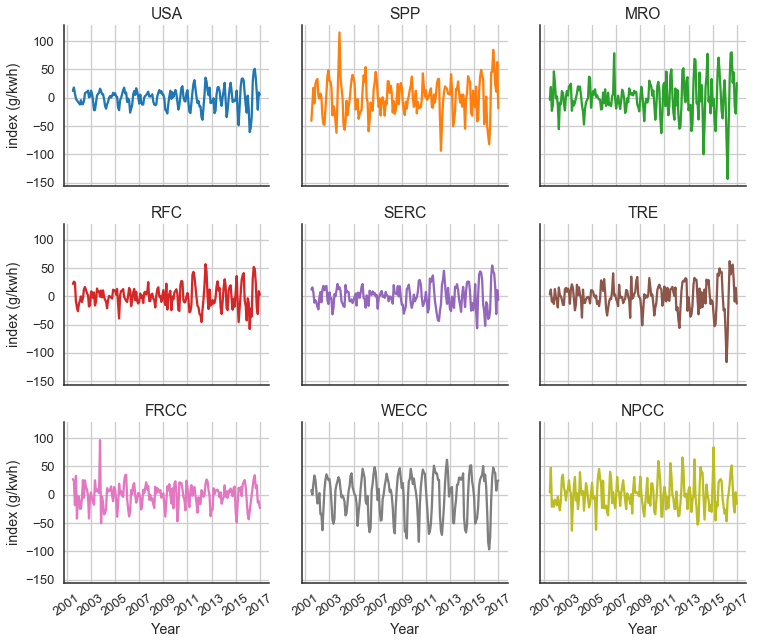

In [57]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

temp = index.copy()
temp.set_index('datetime', inplace=True)

df_list = []
for nerc in order:
    # Subtract the rolling mean from the raw data in each region
    sd = (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
          - (temp.loc[temp['nerc'] == nerc, 'index (g/kwh)']
             .rolling(12, center=True)
             .mean()))
    # Have to make the series into a df to add the 'nerc' column
    sd = pd.DataFrame(sd)
    sd['nerc'] = nerc
    df_list.append(sd)
    
detrend_index = pd.concat(df_list)

region_facet_grid(df=detrend_index.reset_index(), plot_function=plt.plot, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  context='talk', font_scale=1)

#### Create a combined figure for the SI
Include the raw monthly data, the rolling mean trend line, and the detrended data

In [58]:
index.head()

change since 2005   datetime  final co2 (kg)  generation (mwh)  \
0           0.076326 2001-01-01    2.149920e+11       332493160.0   
1           0.060812 2001-02-01    1.803140e+11       282940198.0   
2           0.046964 2001-03-01    1.891340e+11       300706544.0   
3           0.046860 2001-04-01    1.748850e+11       278078871.0   
4           0.048337 2001-05-01    1.892470e+11       300491621.0   

   index (g/kwh)  index (lb/mwh)  month nerc  quarter  year  
0     646.604591     1425.504481      1  USA      1.0  2001  
1     637.284923     1404.958340      2  USA      1.0  2001  
2     628.965732     1386.617853      3  USA      1.0  2001  
3     628.902838     1386.479197      4  USA      2.0  2001  
4     629.790069     1388.435187      5  USA      2.0  2001

In [59]:
detrend_index.head()

index (g/kwh) nerc
datetime                      
2001-01-01            NaN  USA
2001-02-01            NaN  USA
2001-03-01            NaN  USA
2001-04-01            NaN  USA
2001-05-01            NaN  USA

In [60]:
combined = index.copy()
combined.set_index(['nerc', 'datetime'], inplace=True)
df = detrend_index.reset_index(drop=False).set_index(['nerc', 'datetime'])
df.columns = ['detrend index']

In [61]:
combined = pd.concat([index.set_index(['nerc', 'datetime']), df])

In [62]:
combined.head()

change since 2005  detrend index  final co2 (kg)  \
nerc datetime                                                       
USA  2001-01-01           0.076326            NaN    2.149920e+11   
     2001-02-01           0.060812            NaN    1.803140e+11   
     2001-03-01           0.046964            NaN    1.891340e+11   
     2001-04-01           0.046860            NaN    1.748850e+11   
     2001-05-01           0.048337            NaN    1.892470e+11   

                 generation (mwh)  index (g/kwh)  index (lb/mwh)  month  \
nerc datetime                                                             
USA  2001-01-01       332493160.0     646.604591     1425.504481    1.0   
     2001-02-01       282940198.0     637.284923     1404.958340    2.0   
     2001-03-01       300706544.0     628.965732     1386.617853    3.0   
     2001-04-01       278078871.0     628.902838     1386.479197    4.0   
     2001-05-01       300491621.0     629.790069     1388.435187    5.0   

                 quarter    year  
nerc datetime                     
USA  2001-01-01      1.0  2001.0  
     2001-02-01      1.0  2001.0  
     2001-03-01      1.0  2001.0  
     2001-04-01      2.0  2001.0  
     2001-05-01      2.0  2001.0

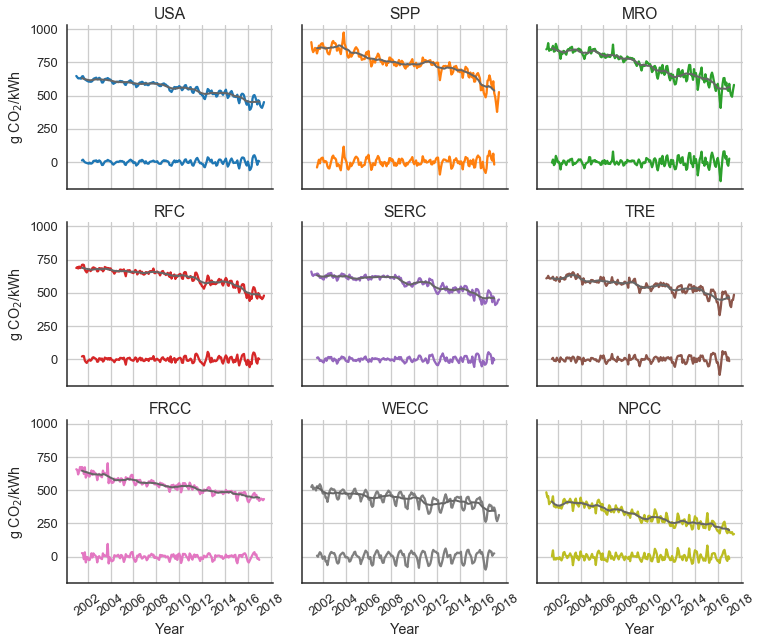

In [63]:
def plot_trend(x, y, **kws):
    'Plot function for the FacetGrid to plot all three data series'
    trend = y.rolling(12, center=True).mean()
    plt.plot(x, y, **kws)
    plt.plot(x, trend, lw=2, c='0.4')
    detrended = y - trend
    plt.plot(x, detrended, **kws)

order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='nerc',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 palette='tab10')

region_facet_grid(df=index.reset_index(), plot_function=plot_trend, x_axis='datetime',
                  add_legend=False, y_axis='index (g/kwh)', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year', 
                  y_label='g CO$_2$/kWh', context='talk', font_scale=1)
path = join(cwd, '..', 'Figures', 'SI',
            'Monthly index trend and detrended by region.pdf')
plt.savefig(path, bbox_inches='tight')

### Percent gen figures

#### Color palette for fuel categories

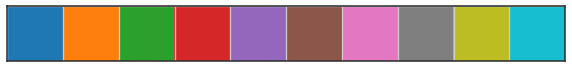

In [64]:
sns.palplot(sns.color_palette('tab10', n_colors=10))

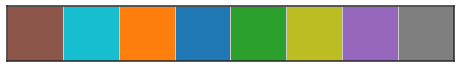

In [45]:
fuel_order = [5, -1, 1, 0, 2, -2, 4, -3]
fuel_palette = [sns.color_palette('tab10', n_colors=10)[x]
                for x in fuel_order]
sns.palplot(fuel_palette)

In [66]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
ASCC Coal          2001-01-01         26493.302    NaN   NaN
                   2001-02-01         31263.704    NaN   NaN
                   2001-03-01         28459.894    NaN   NaN
                   2001-04-01         20455.924    NaN   NaN
                   2001-05-01         24096.734    NaN   NaN

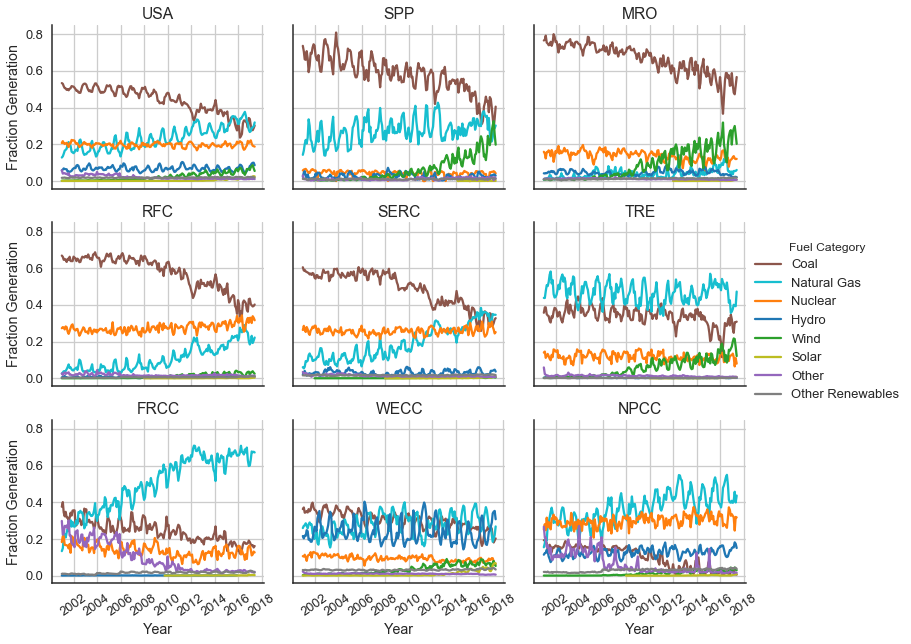

In [29]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
temp = per_gen.copy()
temp.rename(columns={'fuel category': 'Fuel Category'}, inplace=True)

FG_kwargs = dict(hue='Fuel Category',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order,
                 palette=fuel_palette)

region_facet_grid(df=temp, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='% generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  y_label='Fraction Generation',
                  context='talk', font_scale=1)

path = join(cwd, '..', 'Figures', 'Generation by fuel_full.pdf')
# plt.savefig(path, bbox_inches='tight')

## Capacity factor of each fuel by month

In [188]:
capacity['Capacity Factor'] = (gen.loc[:, 'generation (mwh)'] 
                               / capacity.loc[:, 'possible gen'])

In [189]:
capacity.head()

active capacity  possible gen  Capacity Factor
nerc fuel category datetime                                                  
ASCC Coal          2001-01-01            117.5       87420.0         0.303058
                   2001-02-01            117.5       78960.0         0.395944
                   2001-03-01            117.5       87420.0         0.325554
                   2001-04-01            117.5       84600.0         0.241796
                   2001-05-01            117.5       87420.0         0.275643

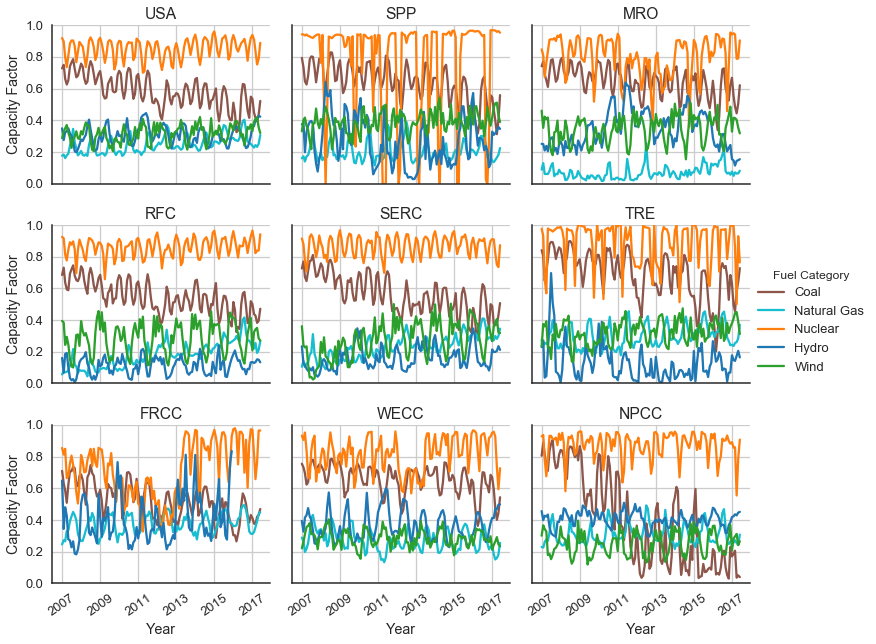

In [81]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
# fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
#               'Other', 'Other Renewables']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind']
temp = capacity.loc[idx[:, fuel_order, :], :].reset_index()
temp.rename(columns={'fuel category': 'Fuel Category'}, inplace=True)

temp = temp.loc[temp['datetime'].dt.year >=2007, :]

FG_kwargs = dict(hue='Fuel Category',
                 col='nerc',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order,
                 palette=fuel_palette,
                 ylim=(0,1))

region_facet_grid(df=temp, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='Capacity Factor', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs, x_label='Year',
                  y_label='Capacity Factor',
                  context='talk', font_scale=1)

path = join(cwd, '..', 'Figures', 'Generation by fuel_full.pdf')
# plt.savefig(path, bbox_inches='tight')

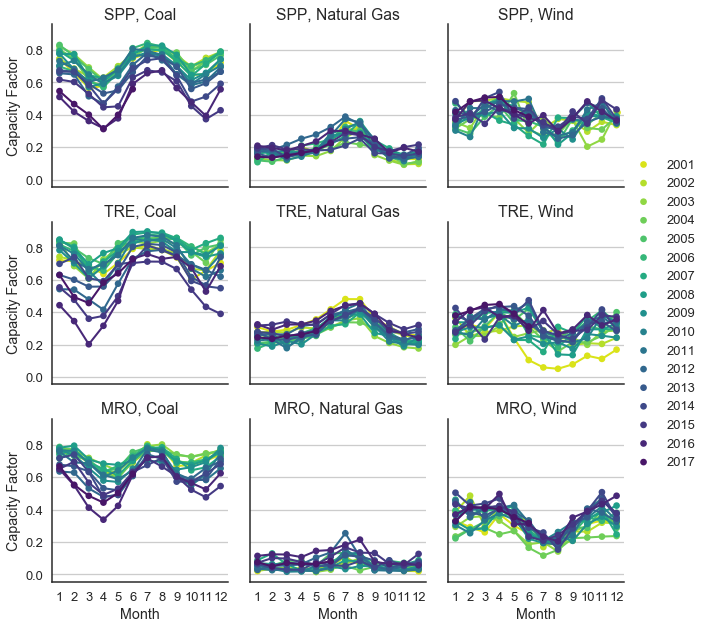

In [191]:
# order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Wind']
temp = capacity.loc[idx[order, fuels, :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year', 
                       data=temp, row='nerc', col='fuel category', 
                       row_order=order, col_order=fuels,
                       palette='viridis_r', scale=0.5, size=3,
                       legend=False)

    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, fuels))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
    plt.tight_layout()
    g.add_legend()
path = join(cwd, '..', 'Figures', 'Three region CF by fuel.pdf')
plt.savefig(path, bbox_inches='tight')

In [202]:
temp = capacity.loc[idx[:, 'Coal', :], :].reset_index()
temp['month'] = temp['datetime'].dt.month
temp['year'] = temp['datetime'].dt.year
temp.loc[(temp['year'] <= 2010) &
         (temp['month'].isin([11,12,1,6,7,8,9])) &
        ~(temp['nerc'].isin(['ASCC', 'FRCC', 'HICC']))].groupby(['nerc', 'month']).mean()

active capacity  possible gen  Capacity Factor    year
nerc month                                                        
MRO  1             23669.24  1.760991e+07         0.763206  2005.5
     6             23825.86  1.715462e+07         0.708589  2005.5
     7             23879.78  1.776656e+07         0.774489  2005.5
     8             23879.78  1.776656e+07         0.766271  2005.5
     9             23879.38  1.719315e+07         0.688218  2005.5
     11            23876.63  1.719117e+07         0.701692  2005.5
     12            23858.45  1.775069e+07         0.756317  2005.5
NPCC 1              6023.85  4.481744e+06         0.822837  2005.5
     6              5938.12  4.275446e+06         0.744006  2005.5
     7              5919.17  4.403862e+06         0.810298  2005.5
     8              5919.17  4.403862e+06         0.809050  2005.5
     9              5919.17  4.261802e+06         0.700285  2005.5
     11             5919.17  4.261802e+06         0.674400  2005.5
     12             5919.17  4.403862e+06         0.768595  2005.5
RFC  1            112200.34  8.347705e+07         0.691271  2005.5
     6            112245.00  8.081640e+07         0.655396  2005.5
     7            112243.42  8.350910e+07         0.698362  2005.5
     8            112243.42  8.350910e+07         0.701922  2005.5
     9            112243.42  8.081526e+07         0.620132  2005.5
     11           112184.33  8.077272e+07         0.607821  2005.5
     12           112142.51  8.343403e+07         0.661097  2005.5
SERC 1             99524.96  7.404657e+07         0.712258  2005.5
     6             99659.86  7.175510e+07         0.731328  2005.5
     7             99659.86  7.414694e+07         0.755396  2005.5
     8             99653.36  7.414210e+07         0.759458  2005.5
     9             99725.36  7.180226e+07         0.687749  2005.5
     11            99782.44  7.184336e+07         0.624033  2005.5
     12            99780.44  7.423665e+07         0.692327  2005.5
SPP  1             20757.60  1.544365e+07         0.769611  2005.5
     6             20764.54  1.495047e+07         0.772493  2005.5
     7             20764.54  1.544882e+07         0.808927  2005.5
     8             20855.94  1.551682e+07         0.802530  2005.5
     9             20855.94  1.501628e+07         0.739742  2005.5
     11            20855.94  1.501628e+07         0.698403  2005.5
     12            20855.94  1.551682e+07         0.761027  2005.5
TRE  1             16750.65  1.246248e+07         0.808363  2005.5
     6             16930.13  1.218969e+07         0.839510  2005.5
     7             16930.13  1.259602e+07         0.849892  2005.5
     8             16930.13  1.259602e+07         0.846848  2005.5
     9             16930.13  1.218969e+07         0.815283  2005.5
     11            16930.13  1.218969e+07         0.731734  2005.5
     12            16930.13  1.259602e+07         0.797274  2005.5
USA  1            325179.07  2.419332e+08         0.724906  2005.5
     6            325635.41  2.344575e+08         0.708048  2005.5
     7            325800.29  2.423954e+08         0.746438  2005.5
     8            325885.19  2.424586e+08         0.748812  2005.5
     9            325956.64  2.346888e+08         0.681339  2005.5
     11           325951.88  2.346854e+08         0.647778  2005.5
     12           325935.69  2.424962e+08         0.705015  2005.5
WECC 1             35445.48  2.637144e+07         0.766956  2005.5
     6             35489.95  2.555276e+07         0.703694  2005.5
     7             35621.44  2.650235e+07         0.768069  2005.5
     8             35621.44  2.650235e+07         0.777334  2005.5
     9             35621.44  2.564744e+07         0.752186  2005.5
     11            35621.44  2.564744e+07         0.746994  2005.5
     12            35667.25  2.653643e+07         0.768416  2005.5

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


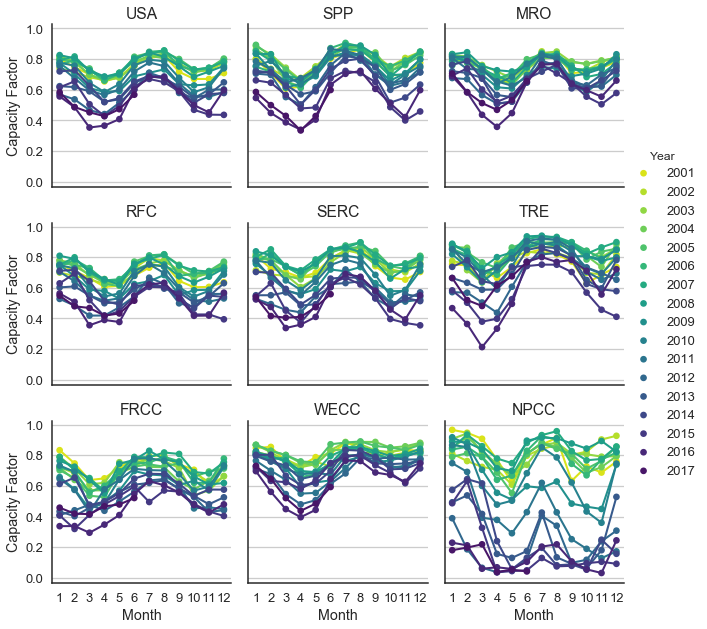

In [174]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity Factor')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

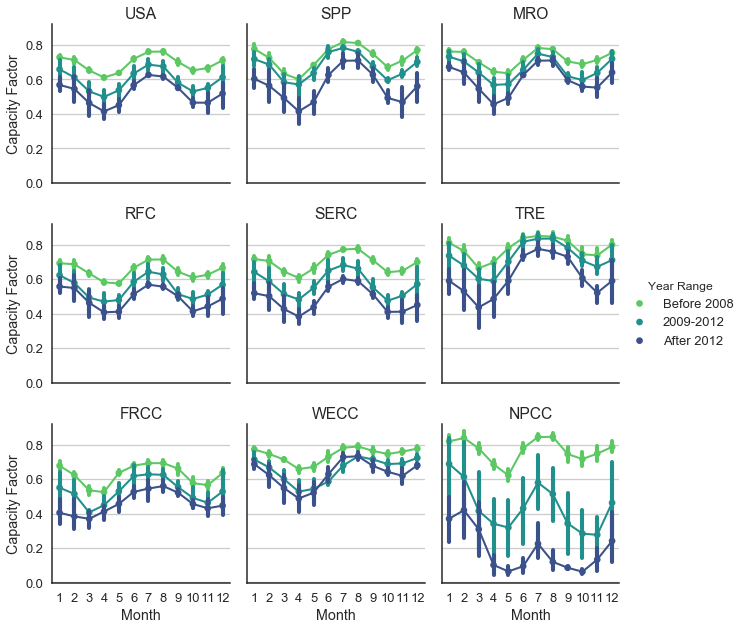

In [204]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

def year_map(year):
    if year <= 2008:
        return 'Before 2008'
    elif year <= 2012:
        return '2009-2012'
    else:
        return 'After 2012'

temp['Year Range'] = temp['Year'].map(year_map)

with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year Range', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity Factor')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

In [83]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
ASCC Coal          2001-01-01         26493.302    NaN   NaN
                   2001-02-01         31263.704    NaN   NaN
                   2001-03-01         28459.894    NaN   NaN
                   2001-04-01         20455.924    NaN   NaN
                   2001-05-01         24096.734    NaN   NaN

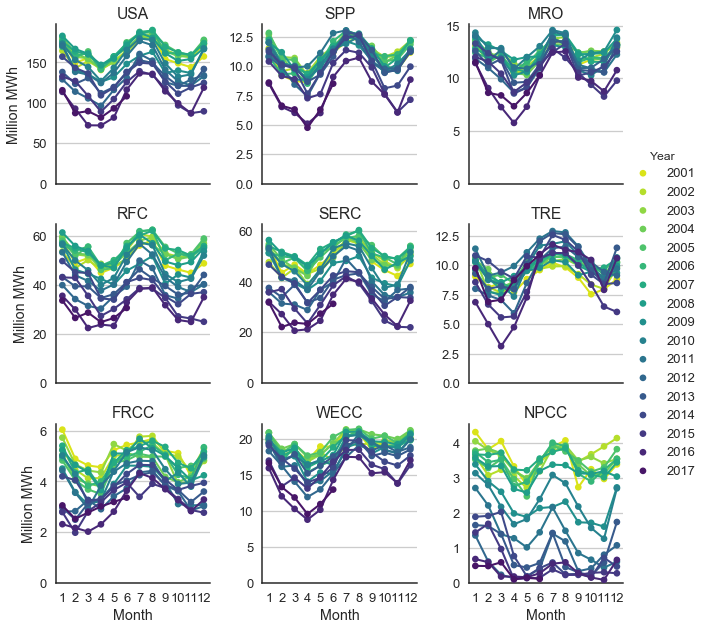

In [85]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = gen.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['million mwh'] = temp['generation (mwh)'] / 1e6

with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='million mwh', hue='Year', sharey=False,
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, None)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Million MWh')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

In [90]:
temp.head()

nerc fuel category   datetime  generation (mwh)  month_x  year_x  Month  \
0  ASCC          Coal 2001-01-01         26493.302      NaN     NaN      1   
1  ASCC          Coal 2001-02-01         31263.704      NaN     NaN      2   
2  ASCC          Coal 2001-03-01         28459.894      NaN     NaN      3   
3  ASCC          Coal 2001-04-01         20455.924      NaN     NaN      4   
4  ASCC          Coal 2001-05-01         24096.734      NaN     NaN      5   

   Year  coal generation  total generation  month_y  year_y  
0  2001         0.026493          1.037344      0.0     0.0  
1  2001         0.031264          0.931171      0.0     0.0  
2  2001         0.028460          1.004722      0.0     0.0  
3  2001         0.020456          0.848567      0.0     0.0  
4  2001         0.024097          0.832705      0.0     0.0

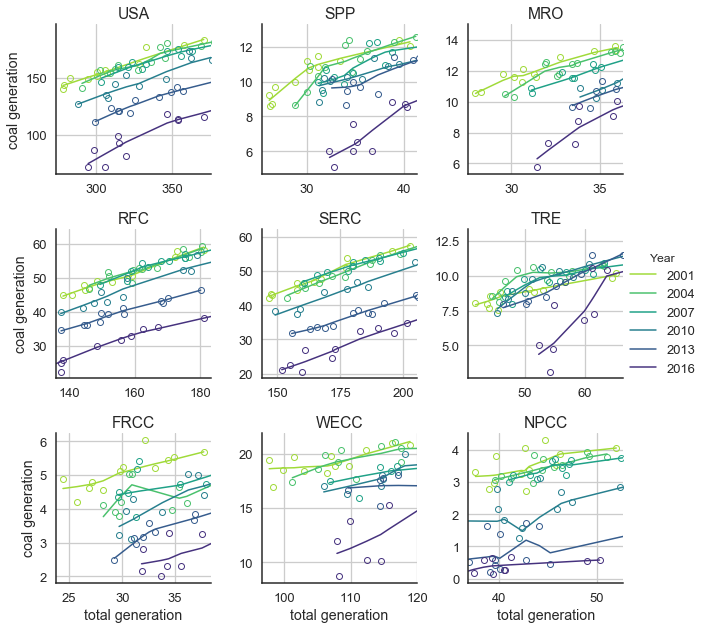

In [112]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
years = range(2001, 2017, 3)
temp = gen.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['coal generation'] = temp['generation (mwh)'] / 1e6
temp = temp.loc[temp['Year'].isin(years), :]

total_gen = (gen.reset_index()
           .groupby(['nerc', 'datetime'])
           .sum()
           .reset_index())
total_gen.rename(columns={'generation (mwh)': 'total generation'}, inplace=True)
total_gen['total generation'] /= 1e6

temp = temp.merge(total_gen, on=['nerc', 'datetime'])

def scatter_coal_total(x, y, *args, **kwargs):
    plt.plot(x, y, 'o', markersize=6, markeredgewidth=1, markerfacecolor='None', **kwargs)
    line_kws = dict(linewidth=1.5)
    sns.regplot(x, y, x_ci=None, lowess=True, n_boot=1, line_kws=line_kws,
                scatter=False, **kwargs)

with sns.plotting_context('talk', font_scale=1):

    g = sns.FacetGrid(data=temp, hue='Year', sharey=False, sharex=False,
                      col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r')
    g.map(scatter_coal_total, 'total generation', 'coal generation')
    g.add_legend()

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, None)
#         ax.set_ylim(0, 1050)
#         if title in ['USA', 'RFC', 'FRCC']:
#             ax.set_ylabel('Million MWh Coal')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')


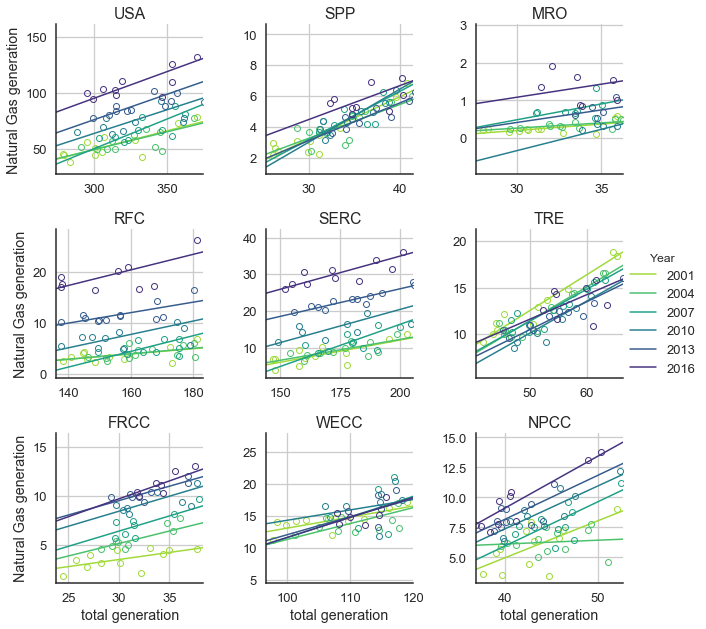

In [111]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
years = range(2001, 2017, 3)
temp = gen.loc[idx[:, 'Natural Gas', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['Natural Gas generation'] = temp['generation (mwh)'] / 1e6
temp = temp.loc[temp['Year'].isin(years), :]

total_gen = (gen.reset_index()
           .groupby(['nerc', 'datetime'])
           .sum()
           .reset_index())
total_gen.rename(columns={'generation (mwh)': 'total generation'}, inplace=True)
total_gen['total generation'] /= 1e6

temp = temp.merge(total_gen, on=['nerc', 'datetime'])

def scatter_coal_total(x, y, *args, **kwargs):
    plt.plot(x, y, 'o', markersize=6, markeredgewidth=1, markerfacecolor='None', **kwargs)
    line_kws = dict(linewidth=1.5)
    sns.regplot(x, y, x_ci=None, n_boot=1, line_kws=line_kws,
                scatter=False, **kwargs)

with sns.plotting_context('talk', font_scale=1):

    g = sns.FacetGrid(data=temp, hue='Year', sharey=False, sharex=False,
                      col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r')
    g.map(scatter_coal_total, 'total generation', 'Natural Gas generation')
    g.add_legend()

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, None)
#         ax.set_ylim(0, 1050)
#         if title in ['USA', 'RFC', 'FRCC']:
#             ax.set_ylabel('Million MWh Coal')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

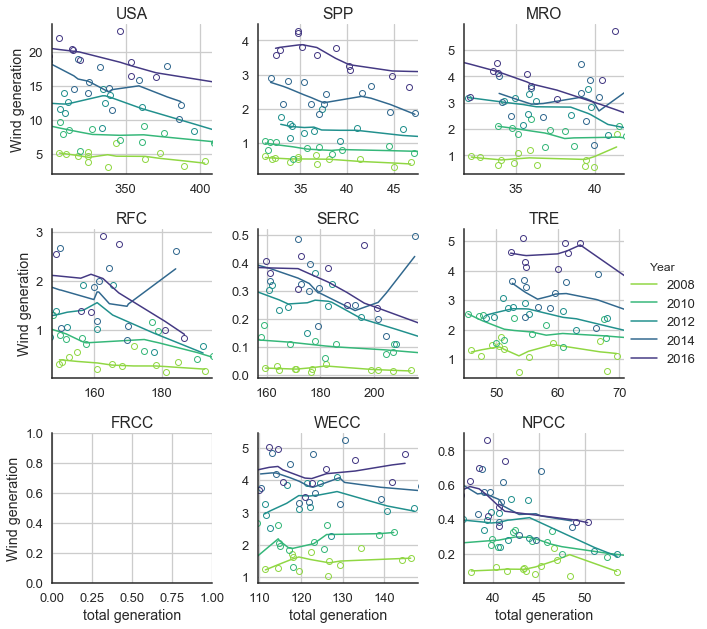

In [197]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
years = range(2008, 2018, 2)
temp = gen.loc[idx[:, 'Wind', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year
temp['Wind generation'] = temp['generation (mwh)'] / 1e6
temp = temp.loc[temp['Year'].isin(years), :]

total_gen = (gen.reset_index()
           .groupby(['nerc', 'datetime'])
           .sum()
           .reset_index())
total_gen.rename(columns={'generation (mwh)': 'total generation'}, inplace=True)
total_gen['total generation'] /= 1e6

temp = temp.merge(total_gen, on=['nerc', 'datetime'])

def scatter_coal_total(x, y, *args, **kwargs):
    plt.plot(x, y, 'o', markersize=6, markeredgewidth=1, markerfacecolor='None', **kwargs)
    line_kws = dict(linewidth=1.5)
    sns.regplot(x, y, x_ci=None, lowess=True, n_boot=1, line_kws=line_kws,
                scatter=False, **kwargs)

with sns.plotting_context('talk', font_scale=1):

    g = sns.FacetGrid(data=temp, hue='Year', sharey=False, sharex=False,
                      col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r')
    g.map(scatter_coal_total, 'total generation', 'Wind generation')
    g.add_legend()

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, None)
#         ax.set_ylim(0, 1050)
#         if title in ['USA', 'RFC', 'FRCC']:
#             ax.set_ylabel('Million MWh Coal')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


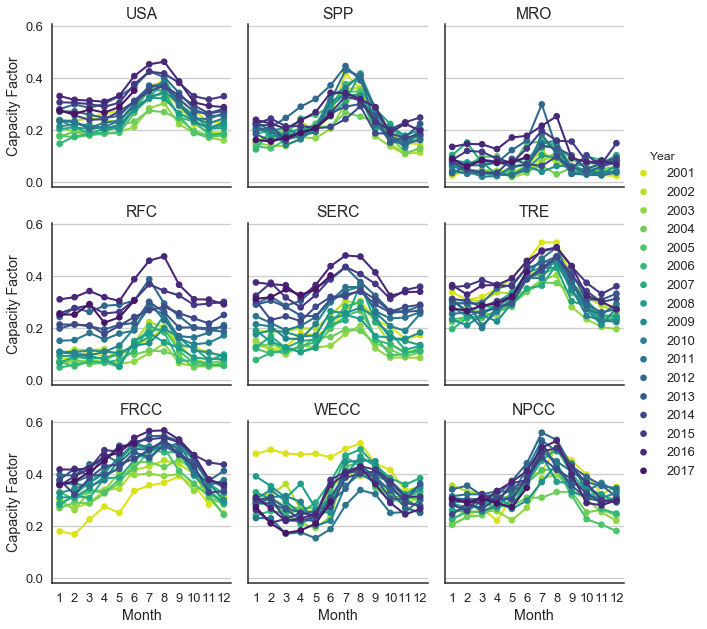

In [180]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.loc[idx[:, 'Natural Gas', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year', 
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity Factor')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

In [34]:
capacity.head()

active capacity  possible gen  Capacity Factor
nerc fuel category datetime                                                  
ASCC Coal          2001-01-01            105.3       78343.2         0.338170
                   2001-02-01            105.3       70761.6         0.441817
                   2001-03-01            105.3       78343.2         0.363272
                   2001-04-01            105.3       75816.0         0.269810
                   2001-05-01            105.3       78343.2         0.307579

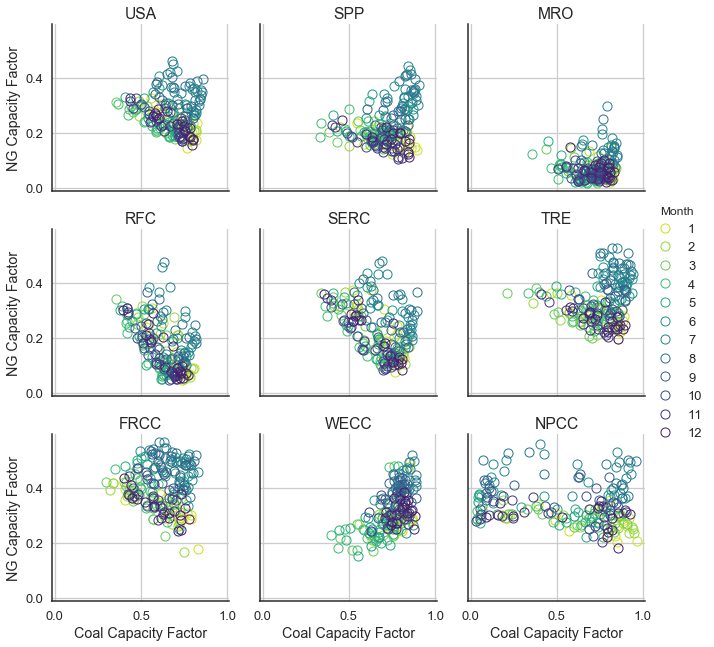

In [42]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.reset_index()#loc[idx[:, 'Natural Gas', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

def scatter_coal_gas(*args, **kwargs):
    data = kwargs.pop('data')
    x = data.loc[data['fuel category'] == 'Coal', 'Capacity Factor']
    y = data.loc[data['fuel category'] == 'Natural Gas', 'Capacity Factor']
    
    plt.plot(x, y, 'o', markeredgewidth=1, markerfacecolor='None', **kwargs)

with sns.plotting_context('talk', font_scale=1):
    g = sns.FacetGrid(temp, col='nerc', col_wrap=3, col_order=order,
                      hue='Month', palette='viridis_r')
    g.map_dataframe(scatter_coal_gas).add_legend()
    
#     g = sns.factorplot(x='Month', y='Capacity Factor', hue='Year', 
#                        data=temp, col='nerc', col_wrap=3, col_order=order, 
#                        palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('NG Capacity Factor')
        if title in ['FRCC', 'WECC', 'NPCC']:
            ax.set_xlabel('Coal Capacity Factor')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

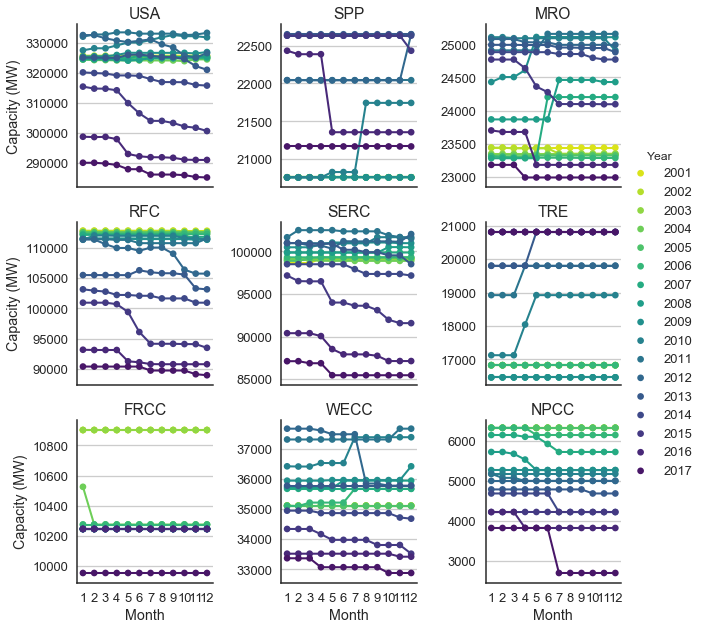

In [114]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp_coal = capacity.loc[idx[:, 'Coal', :], :].reset_index()
temp_coal['Month'] = temp_coal['datetime'].dt.month
temp_coal['Year'] = temp_coal['datetime'].dt.year

with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='active capacity', hue='Year', sharey=False,
                       data=temp_coal, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity (MW)')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

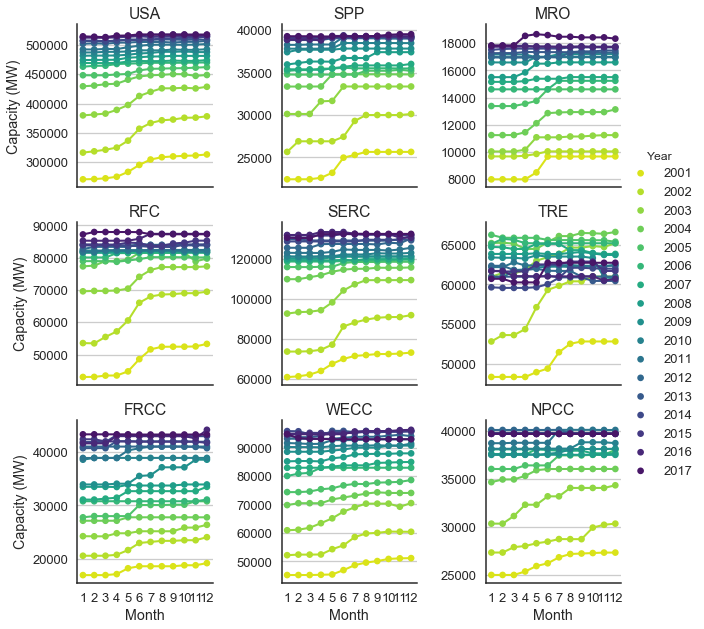

In [116]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.loc[idx[:, 'Natural Gas', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='active capacity', hue='Year', sharey=False,
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity (MW)')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

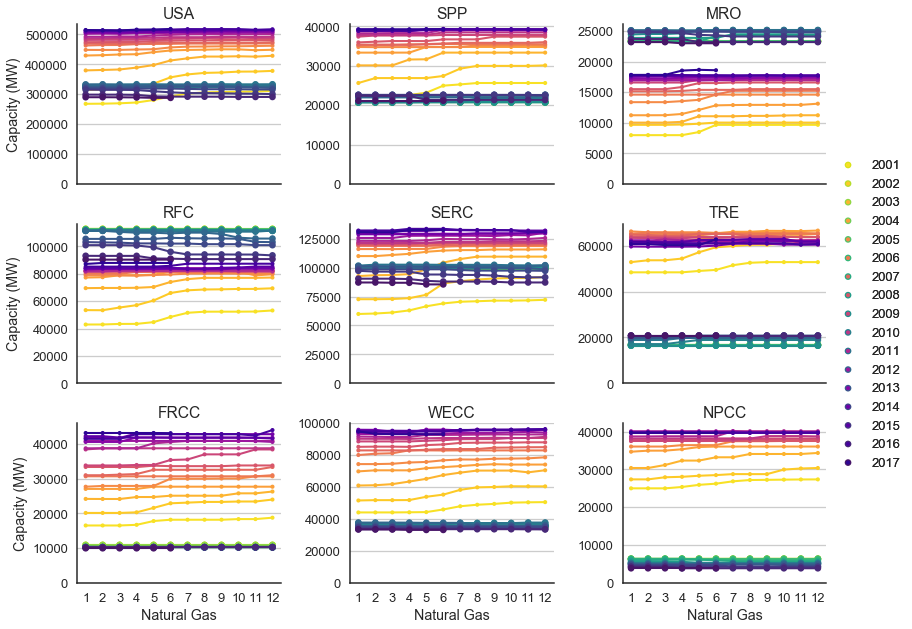

In [192]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = capacity.reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

def capacity_plot(fuel, palette, marker, *args, **kwargs):
    data = kwargs.pop('data')
    fuel_data = data.loc[data['fuel category'] == fuel]
#     ng_data = data.loc[data['fuel category'] == 'Natural Gas']
    
    sns.pointplot(x='Month', y='active capacity', hue='Year', sharey=False,
                   data=fuel_data, palette=palette, scale=0.5, markers=marker)

with sns.plotting_context('talk', font_scale=1):

#     g = sns.factorplot(x='Month', y='active capacity', hue='Year', sharey=False,
#                        data=temp, col='nerc', col_wrap=3, col_order=order, 
#                        palette='viridis_r', scale=0.5, size=3)

    g = sns.FacetGrid(temp, col='nerc', col_wrap=3, col_order=order,
                      sharey=False, aspect=1.2)
    g.map_dataframe(capacity_plot, 'Coal', 'viridis_r', 'o').add_legend()
    g.map_dataframe(capacity_plot, 'Natural Gas', 'plasma_r', '.').add_legend()

    

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, None)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Capacity (MW)')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

In [175]:
gen.head()

generation (mwh)  month  year
nerc fuel category datetime                                 
ASCC Coal          2001-01-01         26493.302    NaN   NaN
                   2001-02-01         31263.704    NaN   NaN
                   2001-03-01         28459.894    NaN   NaN
                   2001-04-01         20455.924    NaN   NaN
                   2001-05-01         24096.734    NaN   NaN

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


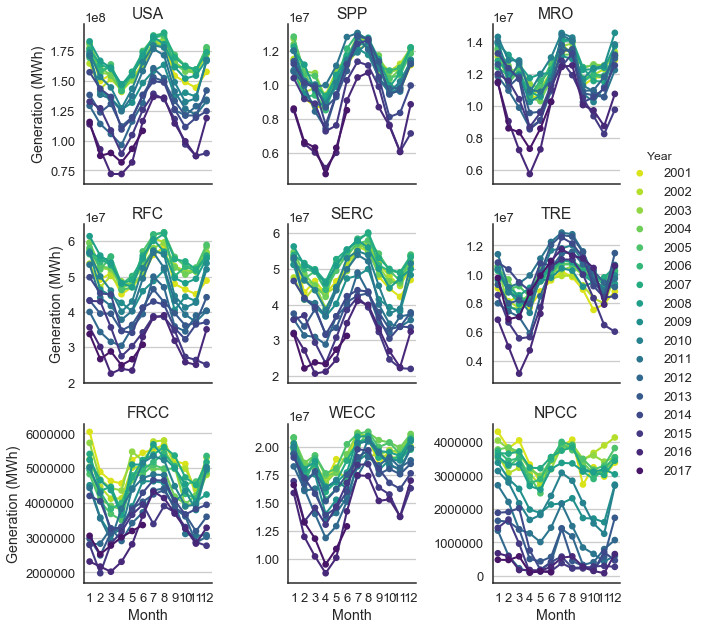

In [177]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = gen.loc[idx[:, 'Coal', :], :].reset_index()
temp['Month'] = temp['datetime'].dt.month
temp['Year'] = temp['datetime'].dt.year

with sns.plotting_context('talk', font_scale=1):

    g = sns.factorplot(x='Month', y='generation (mwh)', hue='Year', sharey=False,
                       data=temp, col='nerc', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5, size=3)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
#         ax.set_ylim(0, 1050)
        if title in ['USA', 'RFC', 'FRCC']:
            ax.set_ylabel('Generation (MWh)')
            
path = join(cwd, '..', 'Figures', 'Monthly index (12-months)_full.pdf')

## Figure of wind, nat gas, and coal
Show how generation from these three resources has changed over time in SPP, TRE, and MRO.

In [208]:
per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].head()

% generation   datetime fuel category  month nerc  year
48      0.515893 2005-01-01          Coal      1  USA  2005
49      0.522003 2005-02-01          Coal      2  USA  2005
50      0.515383 2005-03-01          Coal      3  USA  2005
51      0.494136 2005-04-01          Coal      4  USA  2005
52      0.488659 2005-05-01          Coal      5  USA  2005

In [209]:
capacity.head()

active capacity  possible gen  Capacity Factor
nerc fuel category datetime                                                  
ASCC Coal          2001-01-01            117.5       87420.0         0.303058
                   2001-02-01            117.5       78960.0         0.395944
                   2001-03-01            117.5       87420.0         0.325554
                   2001-04-01            117.5       84600.0         0.241796
                   2001-05-01            117.5       87420.0         0.275643

In [210]:
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
per_gen.year = per_gen.year.astype(int)
temp_df = per_gen.loc[(per_gen['fuel category'].isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (per_gen.nerc.isin(order)) &
                             (per_gen.year >= 2005)].copy()

def early_late(x):
    'Add classifications to each month based on the year'
    if x <= 2008:
        return '2005-2008'
    elif x <= 2012:
        return '2009-2012'
    elif x <= 2016:
        return '2013-2016'
    else:
        return ValueError

temp_df.loc[:, 'timeframe'] = temp_df.loc[:, 'year'].map(early_late)
merge_cols = ['nerc', 'month', 'year']
temp_df = pd.merge(temp_df, index[merge_cols + ['generation (mwh)']],
                   on=merge_cols)
temp_df['generation'] = (temp_df.loc[:, '% generation']
                         * temp_df.loc[:, 'generation (mwh)'] / 1e6)

temp_df = temp_df.merge(capacity.reset_index(), how='left',
                        on=['nerc', 'fuel category', 'datetime'])

In [211]:
temp_df.head()

% generation   datetime fuel category  month nerc  year  timeframe  \
0      0.749050 2005-01-01          Coal      1  MRO  2005  2005-2008   
1      0.028764 2005-01-01   Natural Gas      1  MRO  2005  2005-2008   
2      0.012269 2005-01-01          Wind      1  MRO  2005  2005-2008   
3      0.755915 2005-02-01          Coal      2  MRO  2005  2005-2008   
4      0.032462 2005-02-01   Natural Gas      2  MRO  2005  2005-2008   

   generation (mwh)  generation  active capacity  possible gen  \
0      1.818608e+07   13.622289          23272.1    17314442.4   
1      1.818608e+07    0.523107          13377.9     9953157.6   
2      1.818608e+07    0.223117           1348.2     1003060.8   
3      1.513102e+07   11.437763          23272.1    15638851.2   
4      1.513102e+07    0.491191          13377.9     8989948.8   

   Capacity Factor  
0         0.786759  
1         0.052557  
2         0.222436  
3         0.731369  
4         0.054638

In [212]:
# a is the list of colors
# Matching fuel colors to the generation plot above
a = fuel_palette[0:2]
a.append(fuel_palette[4])

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


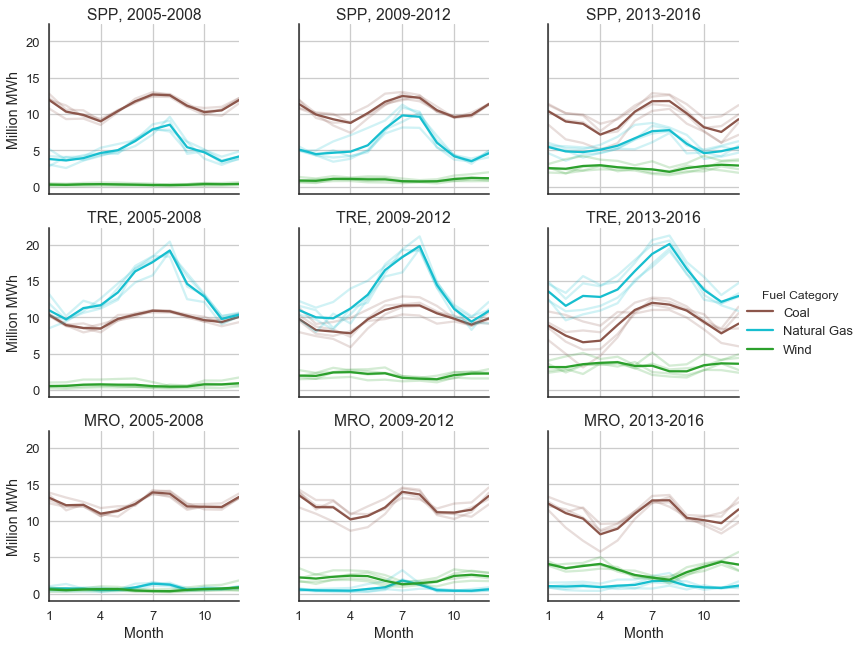

In [75]:
order = ['SPP', 'TRE', 'MRO']
col_order = ['2005-2008', '2009-2012', '2013-2016']

with sns.plotting_context(font_scale=1.2):
    g = sns.FacetGrid(temp_df, col='timeframe', row='nerc',
                      col_order=col_order, row_order=order, aspect=1.15)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces',
                    color=a).add_legend(title='Fuel Category')
    g.set_axis_labels('Month', 'Million MWh')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, col_order))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])

path = join(cwd, '..', 'Figures', 'Wind-Coal-NG variability tsplot.pdf')
plt.savefig(path, bbox_inches='tight')

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


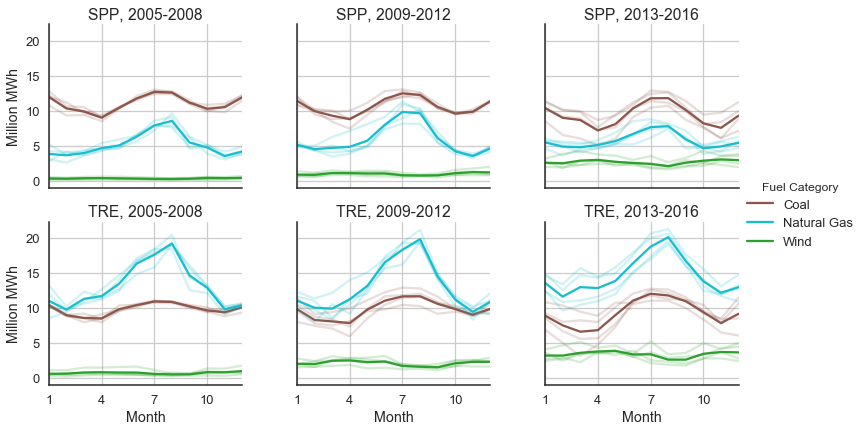

In [34]:
order = ['SPP', 'TRE']#, 'MRO']
col_order = ['2005-2008', '2009-2012', '2013-2016']

with sns.plotting_context(font_scale=1.2):
    g = sns.FacetGrid(temp_df, col='timeframe', row='nerc',
                      col_order=col_order, row_order=order, aspect=1.15)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
                    condition='fuel category', err_style='unit_traces',
                    color=a).add_legend(title='Fuel Category')
    g.set_axis_labels('Month', 'Million MWh')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, col_order))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])

path = join(cwd, '..', 'Figures', 'Wind-Coal-NG variability tsplot.pdf')
# plt.savefig(path, bbox_inches='tight')

In [35]:
temp_df.head()

% generation   datetime fuel category  month nerc  year  timeframe  \
0      0.749050 2005-01-01          Coal      1  MRO  2005  2005-2008   
1      0.028764 2005-01-01   Natural Gas      1  MRO  2005  2005-2008   
2      0.012269 2005-01-01          Wind      1  MRO  2005  2005-2008   
3      0.755915 2005-02-01          Coal      2  MRO  2005  2005-2008   
4      0.032462 2005-02-01   Natural Gas      2  MRO  2005  2005-2008   

   generation (mwh)  generation  
0      1.818608e+07   13.622289  
1      1.818608e+07    0.523107  
2      1.818608e+07    0.223117  
3      1.513102e+07   11.437763  
4      1.513102e+07    0.491191

In [36]:
temp_df.tail()

% generation   datetime fuel category  month nerc  year  \
1345      0.392830 2017-05-01   Natural Gas      5  TRE  2017   
1346      0.171060 2017-05-01          Wind      5  TRE  2017   
1347      0.308400 2017-06-01          Coal      6  TRE  2017   
1348      0.472457 2017-06-01   Natural Gas      6  TRE  2017   
1349      0.120859 2017-06-01          Wind      6  TRE  2017   

                 timeframe  generation (mwh)  generation  
1345  <class 'ValueError'>      3.235857e+07   12.711401  
1346  <class 'ValueError'>      3.235857e+07    5.535247  
1347  <class 'ValueError'>      3.535294e+07   10.902854  
1348  <class 'ValueError'>      3.535294e+07   16.702750  
1349  <class 'ValueError'>      3.535294e+07    4.272710

In [213]:
rolling_var_list = []
for nerc in ['TRE', 'SPP', 'MRO']:
    for fuel in ['Coal', 'Natural Gas', 'Wind']:
        _df = temp_df.loc[(temp_df['nerc'] == nerc) &
                          (temp_df['fuel category'] == fuel),
                         ['nerc', 'fuel category', 'datetime', 'generation']]
        _df['variability'] = (_df['generation']
                              .rolling(24, center=True)
                              .std())
        
        rolling_var_list.append(_df)
        
rolling_var_df = pd.concat(rolling_var_list)

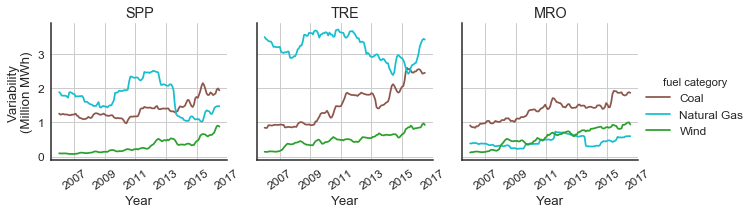

In [214]:
g = sns.FacetGrid(rolling_var_df, hue='fuel category', col='nerc', 
                  col_order=['SPP', 'TRE', 'MRO'], palette=a)
g.map(plt.plot, 'datetime', 'variability').add_legend()
g.set_xticklabels(rotation=35)

g.set_axis_labels('Year', 'Variability\n(Million MWh)')
axes = g.axes.flatten()
for ax, nerc in zip(axes, ['SPP', 'TRE', 'MRO']):
    ax.set_title(nerc)

path = join(cwd, '..', 'Figures', 'SI', 'Wind-Coal-NG rolling variability.pdf')
plt.savefig(path, bbox_inches='tight')

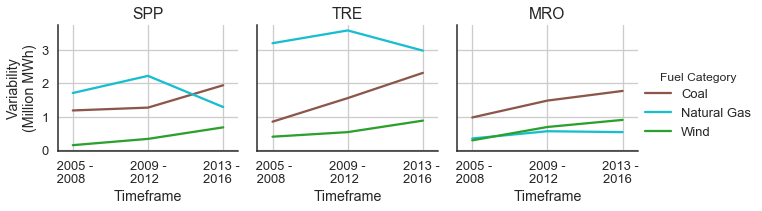

In [76]:
# Map quantitative values to the timeframes to make plotting easier
map_timeframe = {'2005-2008': 0,
                 '2009-2012': 0.5,
                 '2013-2016': 1}

data = (temp_df.groupby(['nerc', 'fuel category', 'timeframe'])
               .std()
               .reset_index())
data['frame'] = data['timeframe'].map(map_timeframe)
data.sort_values(['nerc', 'fuel category', 'frame'], inplace=True)

g = sns.FacetGrid(data, hue='fuel category', col='nerc',
                  col_order=['SPP', 'TRE', 'MRO'], palette=a)
g.map(plt.plot, 'frame', 'generation').add_legend(title='Fuel Category')
g.set_axis_labels('Timeframe', 'Variability\n(Million MWh)')
axes = g.axes.flatten()
for ax, nerc in zip(axes, ['SPP', 'TRE', 'MRO']):
    ax.set_title(nerc)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([' 2005 -\n 2008  ', '2009 -\n2012  ',
                        '2013 - \n2016   '])
    ax.set_xlim(-.1, 1.1)


path = join(cwd, '..', 'Figures', 'SI', 'Wind-Coal-NG variability.pdf')
plt.savefig(path, bbox_inches='tight')

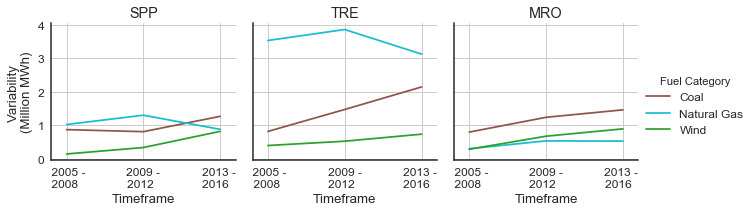

In [35]:
# Map quantitative values to the timeframes to make plotting easier
map_timeframe = {'2005-2008': 0,
                 '2009-2012': 0.5,
                 '2013-2016': 1}

data = (temp_df.groupby(['nerc', 'fuel category', 'timeframe'])
               .std()
               .reset_index())
data['frame'] = data['timeframe'].map(map_timeframe)
data.sort_values(['nerc', 'fuel category', 'frame'], inplace=True)

g = sns.FacetGrid(data, hue='fuel category', col='nerc',
                  col_order=['SPP', 'TRE', 'MRO'], palette=a)
g.map(plt.plot, 'frame', 'generation').add_legend(title='Fuel Category')
g.set_axis_labels('Timeframe', 'Variability\n(Million MWh)')
axes = g.axes.flatten()
for ax, nerc in zip(axes, ['SPP', 'TRE', 'MRO']):
    ax.set_title(nerc)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([' 2005 -\n 2008  ', '2009 -\n2012  ',
                        '2013 - \n2016   '])
    ax.set_xlim(-.1, 1.1)


path = join(cwd, '..', 'Figures', 'SI', 'Wind-Coal-NG variability.pdf')
plt.savefig(path, bbox_inches='tight')

## Correlation figures
Creating a wide dataframe and then melting it to a tidy one is extra work. Might want to come back and create a tidy df from the start.

In [86]:
# Pairs of adjacent NERC regions
region_pairs = [
#     ('WECC', 'MRO'),
    ('WECC', 'SPP'),
    ('WECC', 'TRE'),
    ('TRE', 'SPP'),
    ('TRE', 'SERC'),
    ('SPP', 'MRO'),
    ('SPP', 'SERC'),
    ('SERC', 'FRCC'),
    ('SERC', 'MRO'),
    ('RFC', 'SERC'),
    ('RFC', 'NPCC'),
    ('RFC', 'MRO'),
    ('MRO', 'NPCC'),
    ('MRO', 'WECC')
]

In [28]:
index.reset_index(inplace=True)
index.set_index(['nerc', 'datetime'], inplace=True)
index.sort_index(inplace=True)

In [29]:
index.head()

index  change since 2005  final co2 (kg)  generation (mwh)  \
nerc datetime                                                                 
ASCC 2001-01-01      0                NaN    2.786751e+08        518671.808   
     2001-02-01      1                NaN    2.705489e+08        465585.412   
     2001-03-01      2                NaN    2.955631e+08        502360.773   
     2001-04-01      3                NaN    2.363164e+08        424283.698   
     2001-05-01      4                NaN    2.312179e+08        416352.432   

                 index (g/kwh)  index (lb/mwh)  month  quarter  year  
nerc datetime                                                         
ASCC 2001-01-01     537.286023             NaN      1      NaN  2001  
     2001-02-01     581.093945             NaN      2      NaN  2001  
     2001-03-01     588.348284             NaN      3      NaN  2001  
     2001-04-01     556.977386             NaN      4      NaN  2001  
     2001-05-01     555.341754             NaN      5      NaN  2001

In [30]:
def add_count(df):
    'Add a 0-indexed column for the regression line'
    nercs = df['variable'].unique()
    for nerc in nercs:
        df.loc[df['variable'] == nerc, 'count'] = range(len(df.loc[df['variable'] == nerc]))

In [152]:
def rolling_corr_plot(index, region_pairs, window, center=True,
                      order=None, legend_order=None, sup_title=None,
                      detrend_series=False, diff=False, annual=False, 
                      seasonal=False, shift=1, fill_alpha=0.3):
    """
    Calculate the rolling correlation of detrended CO2 intensity between pairs
    of regions. Multiple detrend methods are possible, but only the "seasonal"
    method is used in the final figures.
    
    inputs:
        index (df): dataframe with monthly co2 intensity of each region
        region_pairs (dict): list of tuples, where each tuple is a pair of
            regions to compare
        window (int): length of the rolling window
        center (bool): if the rolling correlation window should be centered
        order (list): order of NERC region facet windows
        legend order (list): order of NERC regions in legend
        sup_title (str): sup title to place above the facet grid
        detrend_series (bool): if the co2 intensity data should be detrended
        diff (bool): use a differencing method to detrend
        annual (bool): use a linear regression detrend separately on each year
        seasonal (bool): detrend with a 12-month rolling mean
        shift (int): value of shift for the diff detrend method (1 = 1 month)
        fill_alpha: alpha value for the 'fill_between' of regplot uncertainty
    """
    
    df = index.copy()
    
    df.reset_index(inplace=True)
    nercs = df['nerc'].unique()
    df.set_index(['nerc', 'datetime'], inplace=True)
    df.sort_index(inplace=True)
    
    df_list = []
    if detrend_series:
        for nerc in nercs:
            if diff:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = \
                    diff_detrend(df.loc[idx[nerc, :], 'index (g/kwh)'], shift)
            
            if annual:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = \
                    annual_detrend(df.loc[idx[nerc, :]])

            if seasonal:
                trend = (df.loc[nerc, 'index (g/kwh)']
                           .rolling(12, center=True)
                           .mean())
                detr = df.loc[nerc, 'index (g/kwh)'] - trend
                detr = pd.DataFrame(detr)
                detr['nerc'] = nerc
                df_list.append(detr)

            else:
                df.loc[idx[nerc, :], 'index (g/kwh)'] = \
                    detrend(df.loc[idx[nerc, :], 'index (g/kwh)'])
        
        if seasonal:
            # Need to concat the list of dataframes
            df = pd.concat(df_list)
            df.reset_index(inplace=True)
            df.set_index(['nerc', 'datetime'], inplace=True)
    
    df.dropna(inplace=True)

    corr_df = pd.concat([(df.loc[regions[0]]['index (g/kwh)']
                            .rolling(window, center=center)
                            .corr(df.loc[regions[1]]['index (g/kwh)']))
                         for regions in region_pairs], axis=1)
    
    # Create columns with the names of each region. Legacy code, but still
    # functional
    cols = ['{} | {}'.format(regions[0], regions[1]) 
            for regions in region_pairs]
    corr_df.columns = cols
    
    # Go from wide-format to tidy
    corr_tidy = pd.melt(corr_df.reset_index(), id_vars=['datetime'],
                        value_name='Correlation')
    corr_tidy['region1'] = corr_tidy['variable'].str.split(' | ').str[0]
    corr_tidy['region2'] = corr_tidy['variable'].str.split(' | ').str[-1]
    
    # Add the 0-indexed 'count' column
    add_count(corr_tidy)
    
    if not order:
        order = ['WECC', 'TRE', 'SPP', 'SERC', 'RFC', 'MRO']
        
    if not legend_order:
        legend_order = ['SPP', 'TRE', 'SERC', 'MRO', 'FRCC', 'NPCC', 'WECC']
    legend_len = len(legend_order)
    
    g = sns.FacetGrid(corr_tidy.dropna(), col='region1', col_wrap=2, aspect=1.3,
                      hue='region2', palette='tab10', size=2.5,
                      hue_order=legend_order)
    # Use regplot to get the regression line, but set scatter marker size to 0
    g.map(sns.regplot, 'count', 'Correlation', scatter=False,#marker='.',
          truncate=True, #scatter_kws={'s': 0},
          line_kws={'lw': 2})

    # regplot only does a scatter - add plt.plot for the lines
    g.map(plt.plot, 'count', 'Correlation')


    # Create custom patch lines for the legend - the default dots were small
    plot_colors = sns.color_palette('tab10', legend_len)
    legend_patches = [mlines.Line2D([], [], color=c) for c in plot_colors]
    legend_data = dict(zip(legend_order, legend_patches))
    g.add_legend(legend_data=legend_data, title='Second Region')

    axes = g.axes.flatten()

    # Grid lines at the start of each even year from 2004-16
    years = range(2004, 2017, 2)
    distance = 24 # months in 2 years
    # tick locations
    x_ticks = [(x * distance) + 6 for x in range(1, 8)]
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_xticks(x_ticks)
        ax.set_xlim(12, None)
        
        # find PolyCollection objects (confidence intervals for regplot) and
        # change the alpha to make them darker
        for collection in ax.collections:
            if isinstance(collection, matplotlib.collections.PolyCollection):
                collection.set_alpha(fill_alpha)

    # Year for the ticklabels
    g.set_xticklabels(years, rotation=35)
    g.set_xlabels('Year')
    
    # Suptitle if desired
    if sup_title:
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(sup_title)

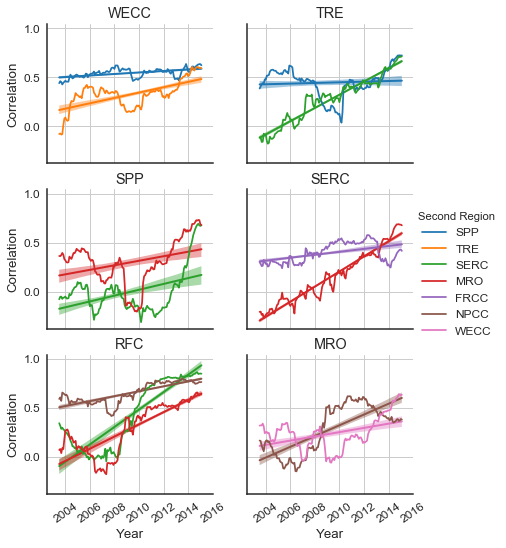

In [89]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                       detrend_series=True, seasonal=True, fill_alpha=0.4)
path = join(cwd, '..', 'Figures', '_Rolling correlation - seasonal detrend 48m centered.pdf')
plt.savefig(path, bbox_inches='tight')

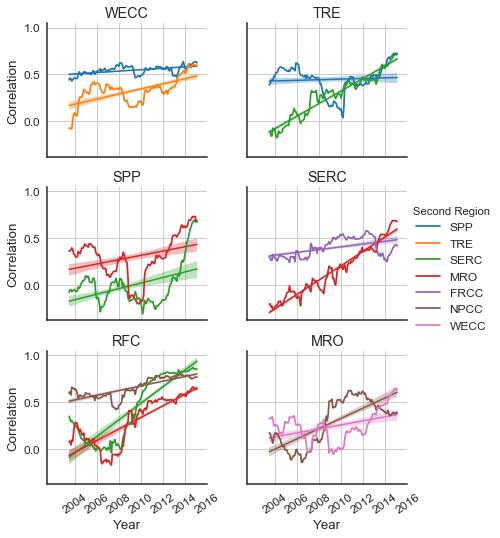

In [127]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                       detrend_series=True, seasonal=True)
path = join(cwd, '..', 'Figures', 'Rolling correlation - seasonal detrend 48m centered.pdf')
# plt.savefig(path, bbox_inches='tight')

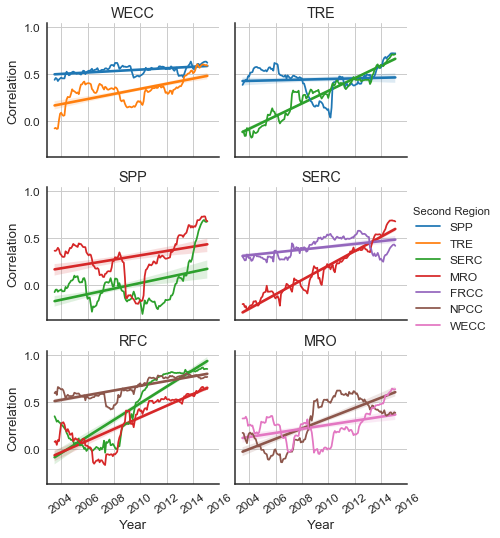

In [38]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,
                       detrend_series=True, seasonal=True)
path = join(cwd, '..', 'Figures', 'Rolling correlation - seasonal detrend 48m centered.pdf')
# plt.savefig(path, bbox_inches='tight')

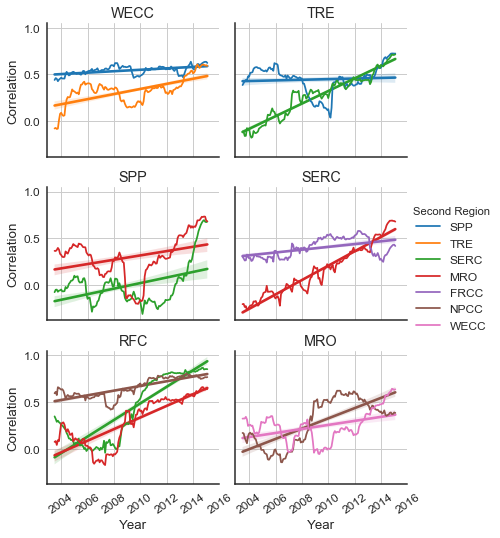

In [34]:
rolling_corr_plot(index, region_pairs=region_pairs, window=48,# x_lim=(2002, 2016),
                       detrend_series=True, seasonal=True)
path = join(cwd, '..', 'Figures', 'Rolling correlation - seasonal detrend 48m centered.pdf')
# plt.savefig(path, bbox_inches='tight')

#### Additional rolling windows for comparison and the SI

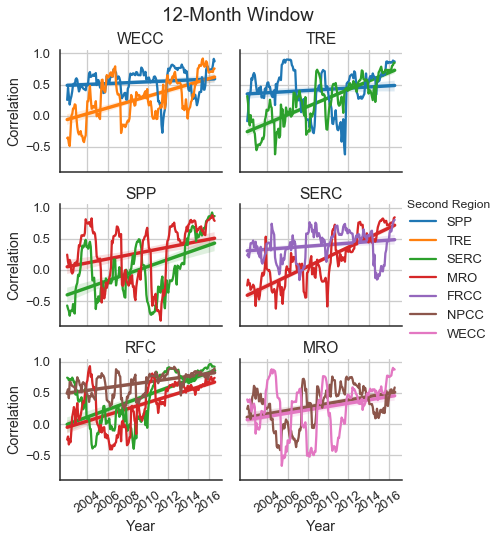

In [85]:
rolling_corr_plot(index, region_pairs=region_pairs, window=12,
                  detrend_series=True, seasonal=True,
                  sup_title='12-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 12m centered.pdf')
plt.savefig(path, bbox_inches='tight')

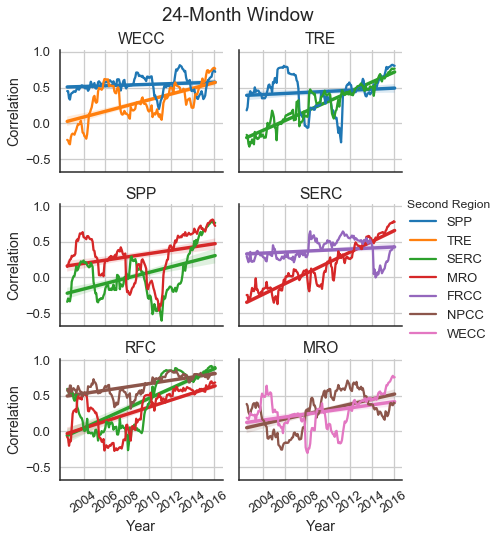

In [86]:
rolling_corr_plot(index, region_pairs=region_pairs, window=24,
                  detrend_series=True, seasonal=True,
                  sup_title='24-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 24m centered.pdf')
plt.savefig(path, bbox_inches='tight')

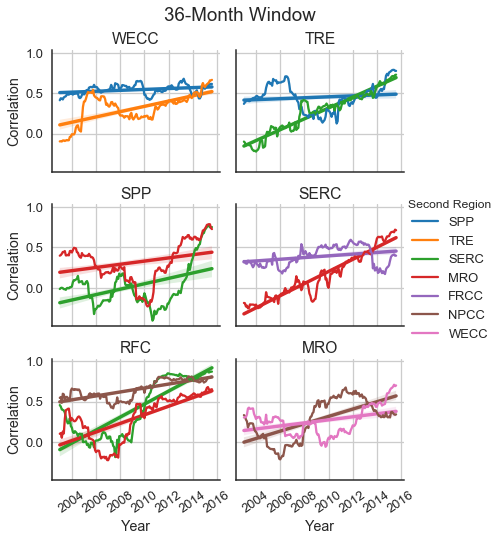

In [87]:
rolling_corr_plot(index, region_pairs=region_pairs, window=36,
                  detrend_series=True, seasonal=True, 
                  sup_title='36-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 36m centered.pdf')
plt.savefig(path, bbox_inches='tight')

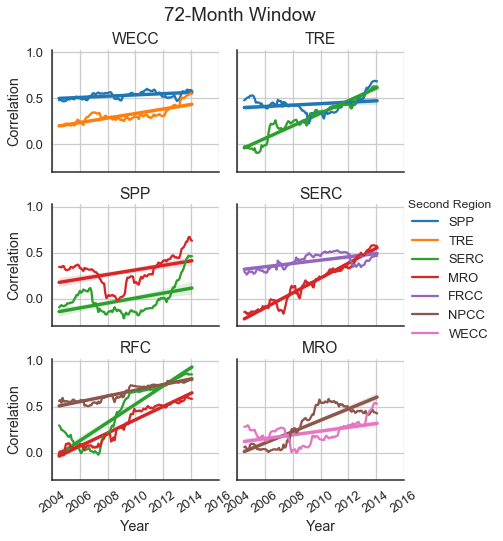

In [88]:
rolling_corr_plot(index, region_pairs=region_pairs, window=72,
                  detrend_series=True, seasonal=True,
                  sup_title='72-Month Window')
path = join(cwd, '..', 'Figures', 'SI',
            'Rolling correlation - seasonal detrend 72m centered.pdf')
plt.savefig(path, bbox_inches='tight')

## Changes in CO₂ intensity for each NERC region

In [89]:
index.head()

index  change since 2005  final co2 (kg)  generation (mwh)  \
nerc datetime                                                                 
ASCC 2001-01-01      0                NaN    2.786751e+08        518671.808   
     2001-02-01      1                NaN    2.705489e+08        465585.412   
     2001-03-01      2                NaN    2.955631e+08        502360.773   
     2001-04-01      3                NaN    2.363164e+08        424283.698   
     2001-05-01      4                NaN    2.312179e+08        416352.432   

                 index (g/kwh)  index (lb/mwh)  month  quarter  year  
nerc datetime                                                         
ASCC 2001-01-01     537.286023             NaN      1      NaN  2001  
     2001-02-01     581.093945             NaN      2      NaN  2001  
     2001-03-01     588.348284             NaN      3      NaN  2001  
     2001-04-01     556.977386             NaN      4      NaN  2001  
     2001-05-01     555.341754             NaN      5      NaN  2001

In [90]:
annual_index = (index.drop('index', axis=1)
                     .reset_index()
                     .groupby(['year', 'nerc'])
                     .sum())
annual_index['index (g/kwh)'] = (annual_index['final co2 (kg)']
                                 / annual_index['generation (mwh)'])
annual_index.sort_index(inplace=True)

In [91]:
annual_index.head()

change since 2005  final co2 (kg)  generation (mwh)  index (g/kwh)  \
year nerc                                                                       
2001 ASCC                NaN    3.080441e+09      5.623967e+06     547.734507   
     FRCC                NaN    1.181516e+11      1.822601e+08     648.258299   
     HICC                NaN    8.294079e+09      1.043156e+07     795.094610   
     MRO                 NaN    1.621590e+11      1.895534e+08     855.479189   
     NPCC                NaN    1.074673e+11      2.577574e+08     416.932116   

           index (lb/mwh)  month  quarter  
year nerc                                  
2001 ASCC             NaN     78      NaN  
     FRCC             NaN     78      NaN  
     HICC             NaN     78      NaN  
     MRO              NaN     78      NaN  
     NPCC             NaN     78      NaN

In [92]:
annual_index.loc[idx[:, 'USA'], :]

change since 2005  final co2 (kg)  generation (mwh)  index (g/kwh)  \
year nerc                                                                       
2001 USA            0.597795    2.358945e+12      3.736644e+09     631.300499   
2002 USA            0.322061    2.382179e+12      3.858452e+09     617.392375   
2003 USA            0.376829    2.407509e+12      3.883185e+09     619.983049   
2004 USA            0.029118    2.391809e+12      3.970555e+09     602.386528   
2005 USA           -0.006476    2.436302e+12      4.055423e+09     600.751673   
2006 USA           -0.276046    2.387001e+12      4.064702e+09     587.251136   
2007 USA           -0.223557    2.451740e+12      4.156745e+09     589.822123   
2008 USA           -0.379183    2.397134e+12      4.119388e+09     581.915115   
2009 USA           -0.985714    2.180357e+12      3.950331e+09     551.942873   
2010 USA           -0.846121    2.308265e+12      4.125060e+09     559.571268   
2011 USA           -1.238876    2.215838e+12      4.100141e+09     540.429717   
2012 USA           -1.747003    2.084286e+12      4.047765e+09     514.922646   
2013 USA           -1.689495    2.102530e+12      4.065964e+09     517.104914   
2014 USA           -1.810320    2.098327e+12      4.104839e+09     511.183794   
2015 USA           -2.408109    1.973672e+12      4.091740e+09     482.355160   
2016 USA           -2.966952    1.868304e+12      4.098546e+09     455.845607   
2017 USA           -1.704432    8.322580e+11      1.930184e+09     431.180754   

           index (lb/mwh)  month  quarter  
year nerc                                  
2001 USA     16684.737740     78     30.0  
2002 USA     16319.549907     78     30.0  
2003 USA     16392.085946     78     30.0  
2004 USA     15931.571617     78     30.0  
2005 USA     15884.430996     78     30.0  
2006 USA     15527.406603     78     30.0  
2007 USA     15596.924419     78     30.0  
2008 USA     15390.810992     78     30.0  
2009 USA     14587.510098     78     30.0  
2010 USA     14772.390698     78     30.0  
2011 USA     14252.218935     78     30.0  
2012 USA     13579.246793     78     30.0  
2013 USA     13655.411123     78     30.0  
2014 USA     13495.388042     78     30.0  
2015 USA     12703.665733     78     30.0  
2016 USA     11963.524997     78     30.0  
2017 USA      5689.124805     21      9.0

Annual CO₂ intensity in 2001 and 2016

In [93]:
annual_index.loc[idx[[2001, 2016], :], 'index (g/kwh)']

year  nerc
2001  ASCC    547.734507
      FRCC    648.258299
      HICC    795.094610
      MRO     855.479189
      NPCC    416.932116
      RFC     688.810285
      SERC    633.560214
      SPP     855.604435
      TRE     610.032666
      USA     631.300499
      WECC    521.636072
2016  ASCC    479.240746
      FRCC    447.770253
      HICC    686.513555
      MRO     555.962598
      NPCC    214.720986
      RFC     494.276060
      SERC    468.600960
      SPP     576.788362
      TRE     458.349631
      USA     455.845607
      WECC    347.723593
Name: index (g/kwh), dtype: float64

Change in CO₂ intensity (absolute and per year) from 2001-2016

In [94]:
(((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])).sort_values(),
((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])).sort_values() / 15)

(nerc
 ASCC     68.493761
 HICC    108.581055
 TRE     151.683035
 SERC    164.959254
 WECC    173.912479
 USA     175.454892
 RFC     194.534225
 FRCC    200.488046
 NPCC    202.211130
 SPP     278.816074
 MRO     299.516591
 Name: index (g/kwh), dtype: float64, nerc
 ASCC     4.566251
 HICC     7.238737
 TRE     10.112202
 SERC    10.997284
 WECC    11.594165
 USA     11.696993
 RFC     12.968948
 FRCC    13.365870
 NPCC    13.480742
 SPP     18.587738
 MRO     19.967773
 Name: index (g/kwh), dtype: float64)

Percent change in CO₂ intensity from 2001-2016

In [96]:
((annual_index.loc[2001, 'index (g/kwh)']
  - annual_index.loc[2016, 'index (g/kwh)'])
 / annual_index.loc[2001, 'index (g/kwh)']).sort_values()

nerc
ASCC    0.125049
HICC    0.136564
TRE     0.248647
SERC    0.260369
USA     0.277926
RFC     0.282421
FRCC    0.309272
SPP     0.325870
WECC    0.333398
MRO     0.350116
NPCC    0.484998
Name: index (g/kwh), dtype: float64